## Introduction

This notebook performs the analyses and produces the figures for:

**Single trial Bayesian inference by population vector readout in the barn owl's sound localization system**

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.io as sio
import math
sns.set_style("white")
from scipy import signal
from google.colab import files

## Parameters

Load the Bayesian model parameters from Fischer and Pena 2011.

In [ ]:
!wget https://www.dropbox.com/s/nyt4amgckltg8zh/PlotData.mat?dl=0 -q

fischer_pena_2011_data = sio.loadmat('PlotData.mat?dl=0', squeeze_me=True)

The methods follow the approach described in Fischer and Peña (2011). Following Fischer and Peña (2011), we model the prior distribution 𝑝(𝜃) of the sound source direction as a Gaussian distribution centered at 0 degrees with a standard deviation of 23.3 degrees.

In [ ]:
sigma_prior = np.sqrt(fischer_pena_2011_data['Parms'][0])

The interaural time difference (ITD) in the auditory input, which is used to infer sound location, is modeled as a sinusoidal function of the sound source azimuth plus Gaussian noise 𝐼𝑇𝐷 = 𝐴 sin(𝜔𝜃) + 𝜂. The parameters 𝐴 = 260 𝜇𝑠 and 𝜔 = 0.0143 radians per degree are determined from the measured relationship between sound source direction and ITD measured from broadband frequency signals recorded at a barn owl’s ears (Hausmann et al., 2009; Fischer and Peña, 2011).

In [ ]:
A = fischer_pena_2011_data['A']

w = fischer_pena_2011_data['w']

sigma_ITD = np.sqrt(fischer_pena_2011_data['Parms'][1])

The preferred directions 𝜃𝑛 are drawn from the Gaussian prior distribution 𝑝(𝜃)

In [ ]:
preferred_directions_2011 = fischer_pena_2011_data['center']

## Simulation and plotting functions

The response of a neuron with preferred direction 𝜃𝑛, denoted
𝑟 (𝐼𝑇𝐷(𝜃)), is drawn from a Poisson distribution with a mean that is proportional to the ITD 𝑛
likelihood function, 𝑎 (𝐼𝑇𝐷(𝜃)) = 𝑟 𝑝(𝐼𝑇𝐷|𝜃 ). Maximum firing rates of OT neurons
decrease as BC decreases (Albeck and Konishi, 1995; Saberi et al., 1998; Cazettes et al., 2016;
Ferger et al., 2021). We thus modeled the maximum firing rate as a quadratic function of BC,
𝑟 = 4.9𝐵𝐶2 + 1.2BC + 0.3, to match experimental observations (Saberi et al., 1998). 𝑚𝑎𝑥
The population vector decoder is a linear combination of the preferred direction vectors:

𝑃𝑉(𝐼𝑇𝐷(𝜃)) = ∑ 𝑟 (𝐼𝑇𝐷(𝜃)) 𝑢(𝜃 )
𝑛=1
where 𝑢(𝜃𝑛) is a unit vector pointing in the direction 𝜃𝑛. The direction estimate from the OT
population response is the direction of the population vector.

In [ ]:
def get_pv_bayes(azimuth, binaural_correlation, best_azimuth, A, w, sigma_ITD):
    """
    This function takes a stimulus azimuth as input, produces a noisy stimulus ITD,
    and computes the Bayesian and population vector estimates of direction.
    """


    max_rate = 4.9 * binaural_correlation**2 + 1.2 * binaural_correlation + 0.3

    # Generate the stimulus ITD with standard deviation depending on binaural correlation
    itd_standard_deviation = sigma_ITD + 219.34*np.exp(-11.31 * binaural_correlation)


    # Generate a noisy ITD observation
    ITD = A * np.sin(w * azimuth) + stats.norm(loc = 0, scale = itd_standard_deviation).rvs()

    # Set up components of Bayesian decoder: (1) x, y components of unit vectors in all directions
    #                                        (2) prior
    #                                        (3) ITD at each direction


    # Bayes model
    direction = np.linspace(-180, 180, 1000)
    d_dir = direction[1] - direction[0]
    x = np.cos(direction * np.pi / 180)
    y = np.sin(direction * np.pi / 180)

    mean_itd = A * np.sin(w * direction)

    prior = stats.norm(loc = 0, scale = sigma_prior).pdf(direction)

    likelihood = stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(mean_itd)

    posterior = prior * likelihood / np.sum(prior * likelihood * d_dir)

    mean_x_component = np.sum(x * posterior) * d_dir

    mean_y_component = np.sum(y * posterior) * d_dir

    bayes_estimate = math.atan2(mean_y_component, mean_x_component) * 180 / np.pi


    # PV

    best_itd = A * np.sin(w * best_azimuth)

    population_rate = max_rate * stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(best_itd) * np.sqrt(2 * np.pi) * sigma_ITD

    population_response = stats.poisson(mu = population_rate).rvs()

    x_pv = np.cos(best_azimuth * np.pi / 180)
    y_pv = np.sin(best_azimuth * np.pi / 180)

    mean_x = np.sum(x_pv * population_response)

    mean_y = np.sum(y_pv * population_response)

    pv_estimate = math.atan2(mean_y, mean_x) * 180 / np.pi

    # Response rates
    num_active = np.sum([population_response >= 1])

    num_spikes = np.sum(population_response)


    return bayes_estimate, pv_estimate, num_active, num_spikes, ITD

In [ ]:
def run_localization_simulation(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth):

    # Get the number of stimulus conditions
    number_azimuths = np.size(stimulus_azimuth)
    number_bcs = np.size(binaural_correlation)

    # Initialize arrays to store the results
    pv_estimate = np.zeros((number_azimuths, number_bcs, number_repetitions))
    bayes_estimate = np.zeros((number_azimuths, number_bcs, number_repetitions))
    number_active_neurons = np.zeros((number_azimuths, number_bcs, number_repetitions))
    number_spikes = np.zeros((number_azimuths, number_bcs, number_repetitions))
    ITD = np.zeros((number_azimuths, number_bcs, number_repetitions))

    for i, azimuth in enumerate(stimulus_azimuth):
        for j, bc in enumerate(binaural_correlation):
            for k in range(number_repetitions):

                bayes_estimate[i, j, k], pv_estimate[i, j, k], number_active_neurons[i, j, k], number_spikes[i, j, k], ITD[i, j, k] = get_pv_bayes(azimuth, bc, best_azimuth, A, w, sigma_ITD)


    # Squeeze results to remove singleton dimensions
    pv_estimate = np.squeeze(pv_estimate)
    bayes_estimate = np.squeeze(bayes_estimate)
    number_active_neurons = np.squeeze(number_active_neurons)
    number_spikes = np.squeeze(number_spikes)

    abs_errror = np.abs(bayes_estimate - pv_estimate)

    number_dimensions = bayes_estimate.ndim

    mean_bayes_estimate = np.mean(bayes_estimate, number_dimensions-1)
    mean_pv_estimate = np.mean(pv_estimate, number_dimensions-1)

    sd_bayes_estimate = np.std(bayes_estimate, number_dimensions-1, ddof = 1)
    sd_pv_estimate = np.std(pv_estimate, number_dimensions-1, ddof = 1)

    return bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD


### Plots

In [ ]:
def plot_prior(preferred_directions):
    """
    This function plots the Gaussian prior and a histogram of the perferred directions
    """
    plt.figure(figsize = (8,6))

    # Plot the histogram of the preferred directions
    sns.histplot(preferred_directions, stat = 'density', alpha = 0.6, color = 'k')

    # Plot the pdf for the prior
    prior = stats.norm(loc = 0, scale = sigma_prior);

    x_bound = np.max([prior.ppf(0.9995),np.max(np.abs(preferred_directions))])
    x_p = np.arange(-x_bound, x_bound)

    plt.plot(x_p, prior.pdf(x_p), 'k', linewidth=3)

    # Formatting
    plt.legend(['Prior', 'Preferred directions'], loc = 'upper left', fontsize = 14, frameon=False)

    plt.tick_params(labelsize = 17)

    plt.xlabel('Direction (deg)', fontsize = 20)
    plt.ylabel('Density', fontsize = 20)

    sns.despine(right=True, top=True)

In [ ]:
def plot_likelihood_population_response(preferred_directions, binaural_correlation, ITD, random_seed=0):

    """
    Plot the likelihood function and the population response spike counts for an ITD and BC
    """

    max_rate = 4.9 * binaural_correlation**2 + 1.2 * binaural_correlation + 0.3

    # Generate the stimulus ITD with standard deviation depending on binaural correlation
    itd_standard_deviation = sigma_ITD + 219.34*np.exp(-11.31 * binaural_correlation)

    # model neural population response
    best_itd = A * np.sin(w * preferred_directions)
    population_rate = max_rate * stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(best_itd) * np.sqrt(2 * np.pi) * itd_standard_deviation
    np.random.seed(seed=random_seed)
    population_response = stats.poisson(mu = population_rate).rvs()

    # Likelihood
    x = np.linspace(-75, 75, 201)
    likelihood = max_rate * stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(A * np.sin(w * x)) * np.sqrt(2 * np.pi) * itd_standard_deviation

    # Plot
    plt.figure(figsize = (8,6))

    plt.plot(x, likelihood, 'k', linewidth=3)

    plt.plot(preferred_directions, population_response,'ko', alpha = 0.6, mec = 'w', ms=6);

    plt.tick_params(labelsize = 17)

    plt.xlabel('Preferred direction (deg)', fontsize = 20)
    plt.ylabel('Spike count', fontsize = 20)

    sns.despine(right=True, top=True)

In [ ]:
def plot_trial_average_estimates(stimulus_azimuth, mean_bayes_estimate, sd_bayes_estimate, mean_pv_estimate, sd_pv_estimate):

    """
    Plot the mean and standard deviation of the Bayesian and population vector estimates over trials.
    """

    plt.figure(figsize = (8,6))

    # Plot the mean and standard deviation
    plt.errorbar(stimulus_azimuth, mean_bayes_estimate, sd_bayes_estimate, marker = 'o', alpha = 0.6, mec = 'w', ms = 9)
    plt.errorbar(stimulus_azimuth, mean_pv_estimate, sd_pv_estimate, marker = 's', alpha = 0.6, mec = 'w', ms = 9)

    # Formatting
    plt.legend(['Bayes', 'Pop. vector'], loc = 'upper left', fontsize = 14, frameon=False)

    plt.tick_params(labelsize = 17)

    plt.xlabel('Target direction (deg)', fontsize = 20)
    plt.ylabel('Estimated direction (deg)', fontsize = 20)

    sns.despine(right=True, top=True)

In [ ]:
def plot_single_trial_estimates(bayes_estimate, pv_estimate, ITD):

    """
    Plot the Bayesian and population vector estimates on each trial as a function of the ITD
    """

    plt.figure(figsize = (8,6))

    # Plot
    plt.scatter(bayes_estimate, pv_estimate, c = ITD, alpha = 0.6, cmap = 'twilight_shifted', edgecolor='lightgray', s=30)

    # Formatting
    cbar = plt.colorbar()
    cbar.set_label('Stimulus ITD ($\mu$s)', fontsize = 17)
    cbar.ax.tick_params(labelsize=15)


    plt.tick_params(labelsize = 17)

    plt.xlabel('Bayes estimate (deg)', fontsize = 20)
    plt.ylabel('Population vector estimate (deg)', fontsize = 20)

    sns.despine(right=True, top=True)

In [ ]:
def plot_error_number_active(bayes_estimate, pv_estimate, number_active_neurons):

    """
    Plot the absolute error between the Bayesian and population vector estimates as a function of the number of active neurons
    """

    # Compute the absolute error
    abs_errror = np.abs(bayes_estimate - pv_estimate)


    plt.figure(figsize = (8,6))

    #Plot
    plt.plot(number_active_neurons, abs_errror, 'ko', alpha = 0.6, mec = 'w', ms = 6)

    # Formatting
    plt.tick_params(labelsize = 17)

    plt.xlabel('Number of active neurons', fontsize = 20)
    plt.ylabel('|Bayes - Pop. vector estimate| (deg)', fontsize = 18);

    sns.despine(right=True, top=True)

# Simulations and figures

## Figure 2

We first show that population vector estimates from the original non-uniform population code model for the barn owl’s optic tectum (OT) (Fischer and Peña, 2011) approximate the Bayesian estimate of sound source direction on single trials.

Run the simulation

In [ ]:
number_repetitions = 50
stimulus_azimuth = np.linspace(-150, 150, 15)
binaural_correlation = np.array([1])

np.random.seed(seed=100)

bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD = run_localization_simulation(stimulus_azimuth, binaural_correlation, number_repetitions, preferred_directions_2011)


Figure 2A

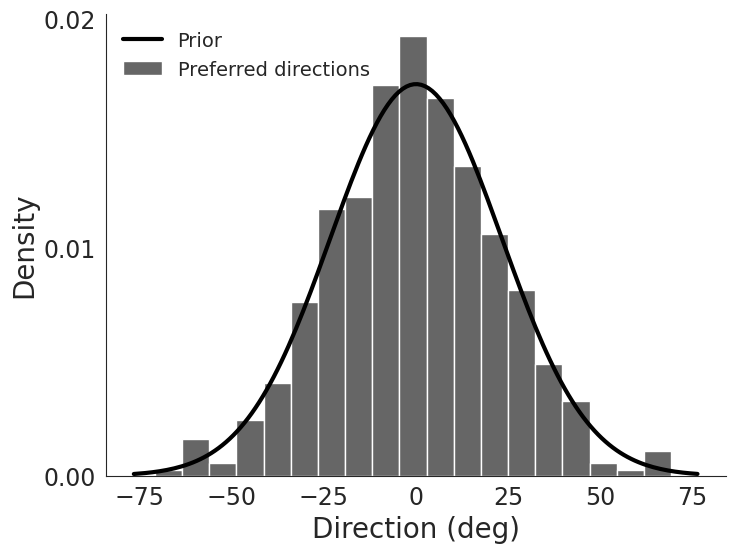

In [ ]:
plot_prior(preferred_directions_2011)

plt.yticks([0, 0.01, 0.02]);

#plt.savefig("Figure2A.png", dpi=500)
#files.download("Figure2A.png")

#plt.show()

Figure 2B

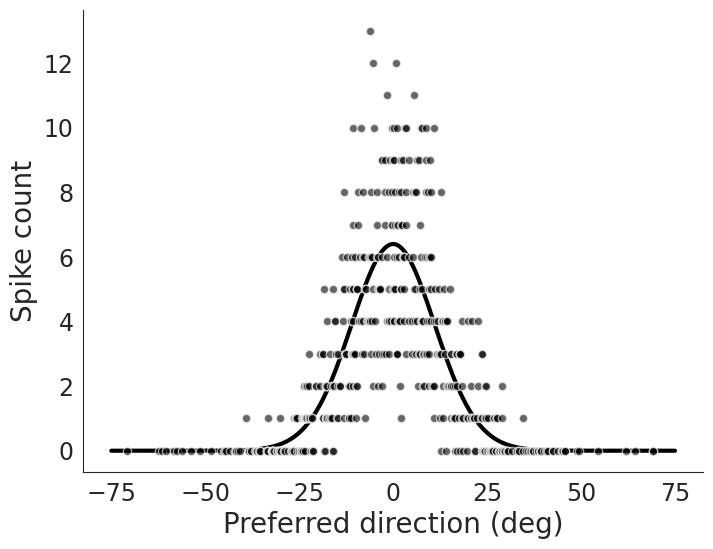

In [ ]:
plot_likelihood_population_response(preferred_directions_2011, binaural_correlation=1, ITD=0, random_seed=0)

#binaural_correlation, ITD, random_seed=0
#plt.savefig("Figure2B.png", dpi=500)
#files.download("Figure2B.png")

plt.show()

Figure 2C

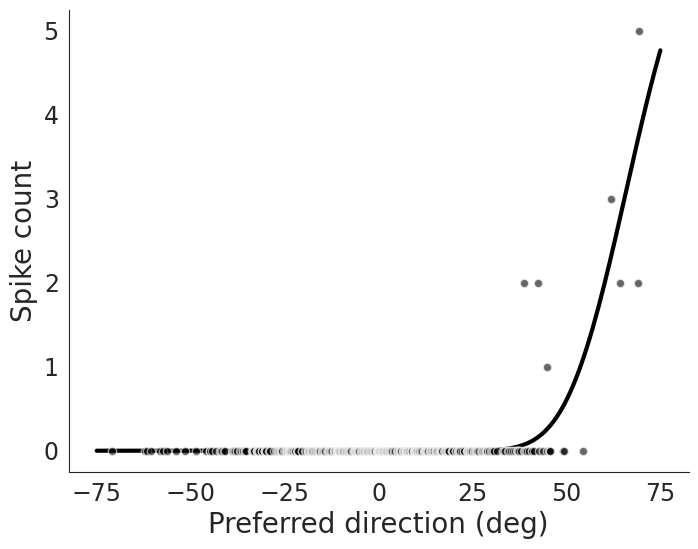

In [ ]:
plot_likelihood_population_response(preferred_directions_2011, binaural_correlation=1, ITD=A, random_seed=0)

#plt.savefig("Figure2C.png", dpi=500)
#files.download("Figure2C.png")

plt.show()

Figure 2D

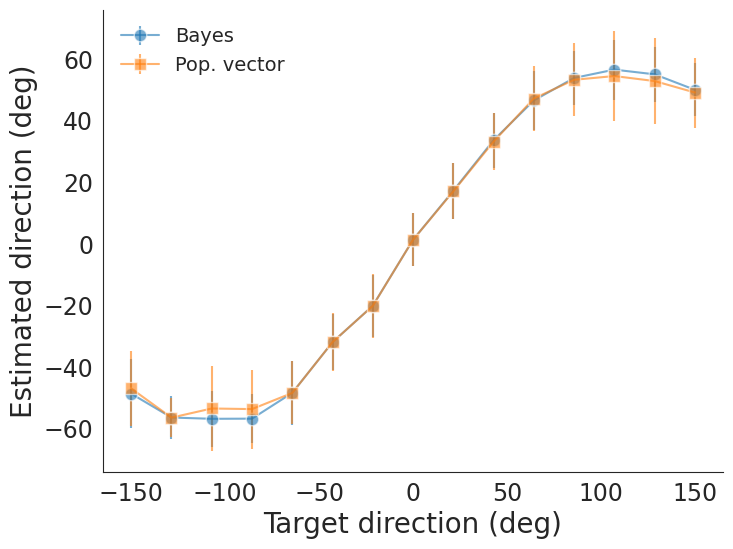

In [ ]:
plot_trial_average_estimates(stimulus_azimuth,
                             mean_bayes_estimate,
                             sd_bayes_estimate,
                             mean_pv_estimate,
                             sd_pv_estimate)

#plt.savefig("Figure2D.png", dpi=500)
#files.download("Figure2D.png")

plt.show()

Figure 2E

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

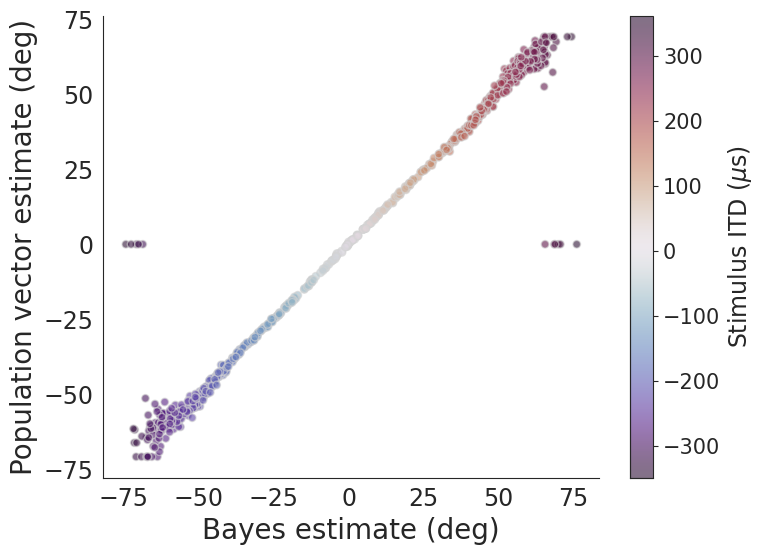

In [ ]:
plot_single_trial_estimates(bayes_estimate, pv_estimate, ITD)
plt.xticks(np.arange(-75, 100, 25))
plt.yticks(np.arange(-75, 100, 25))


plt.savefig("Figure2E.png", dpi=500)
files.download("Figure2E.png")

plt.show()

Figure 2F

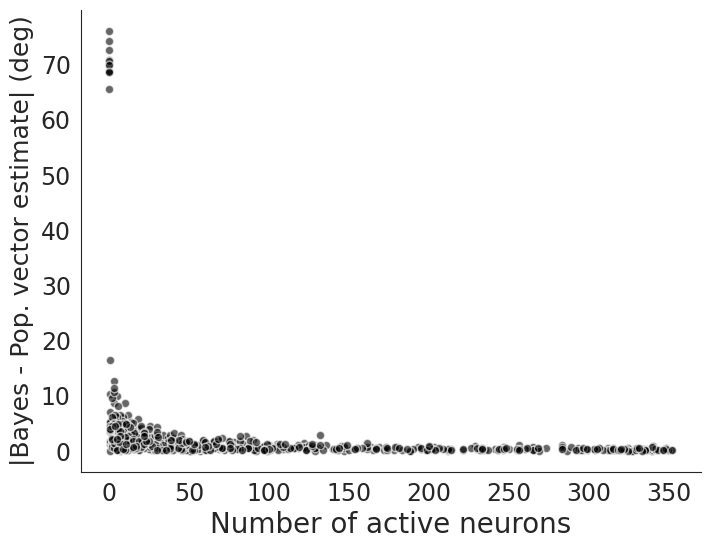

In [ ]:
plot_error_number_active(bayes_estimate, pv_estimate, number_active_neurons)

#plt.savefig("Figure2F.png", dpi=500)
#files.download("Figure2F.png")

plt.show()

## Figure 3

We next showed that the population vector accurately approximates the Bayesian estimate on single trials for source directions around the head for a larger population.

Create the preferred directions for the 25,000 neuron population.

In [ ]:
N2 = 25_000

prior = stats.norm(loc = 0, scale = sigma_prior)

np.random.seed(seed=1)

best_azimuth_large = prior.rvs(size = N2)

Run the simulation

In [ ]:
number_repetitions = 50
stimulus_azimuth = np.linspace(-150, 150, 15)
binaural_correlation = np.array([1])

np.random.seed(seed=150)

bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD = run_localization_simulation(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth_large)

Figure 3A

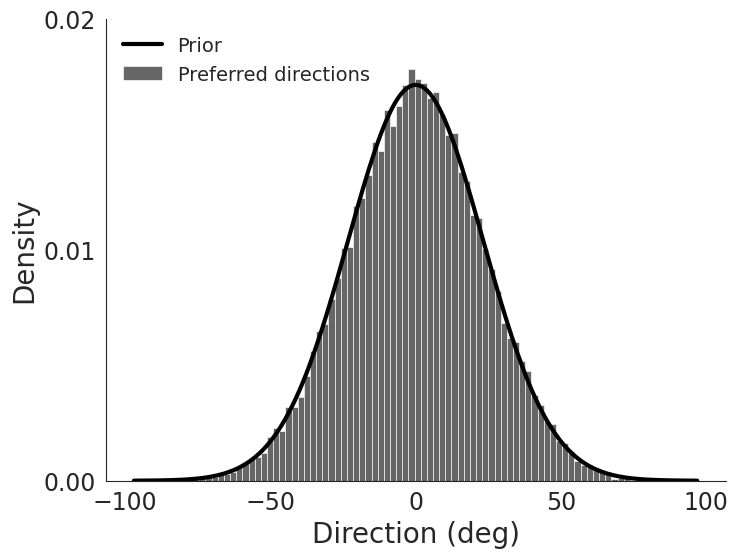

In [ ]:
plot_prior(best_azimuth_large)

plt.yticks([0, 0.01, 0.02]);


#plt.savefig("Figure3A.png", dpi=500)
#files.download("Figure3A.png")

plt.show()

Figure 3B

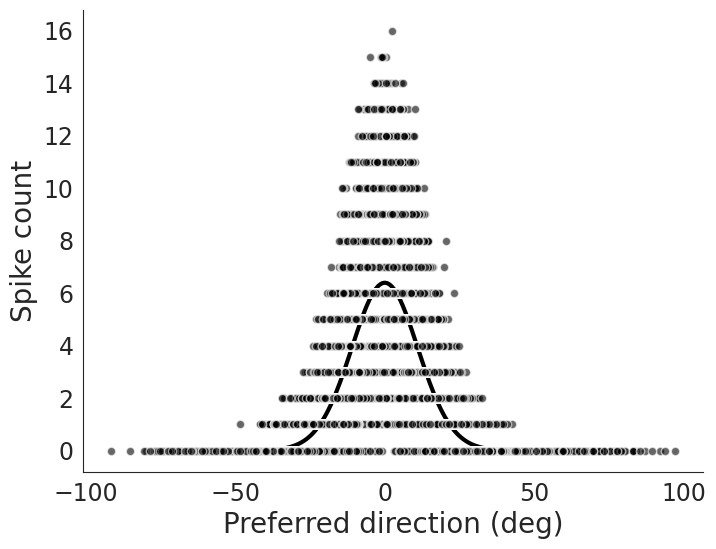

In [ ]:
plot_likelihood_population_response(best_azimuth_large, 1, 0, 0)

#plt.savefig("Figure3B.png", dpi=500)
#files.download("Figure3B.png")

plt.show()

Figure 3C

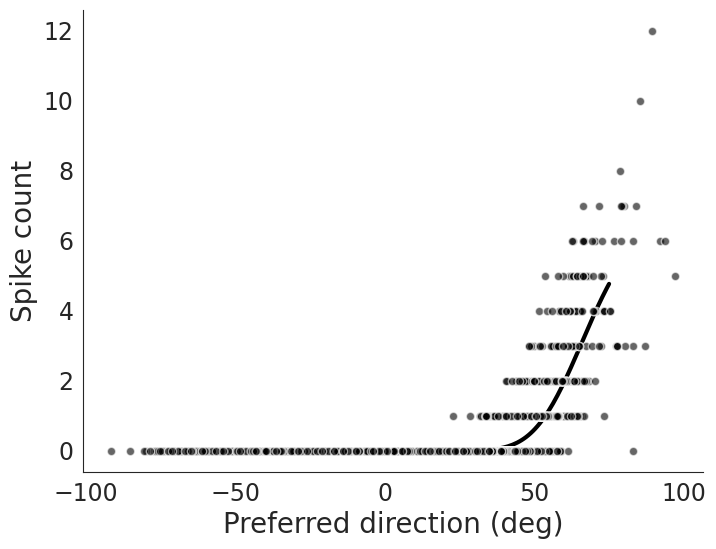

In [ ]:
plot_likelihood_population_response(best_azimuth_large, 1, A, 0)

#plt.savefig("Figure3C.png", dpi=500)
#files.download("Figure3C.png")

plt.show()

Figure 3D

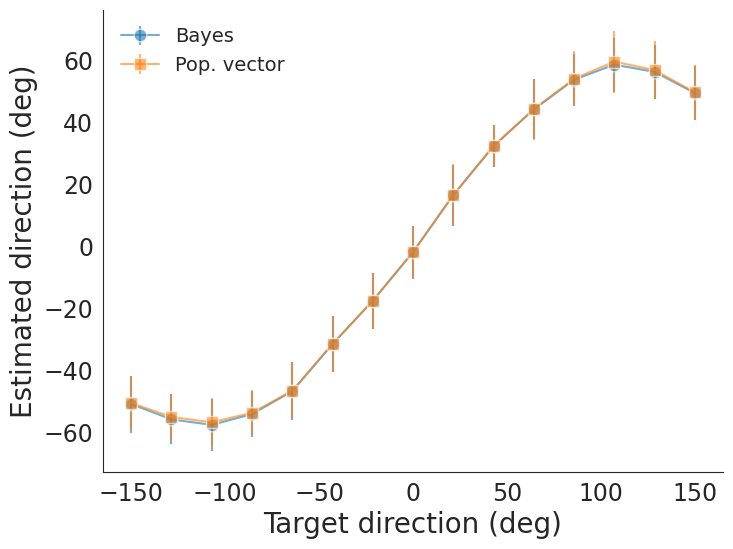

In [ ]:
plot_trial_average_estimates(stimulus_azimuth, mean_bayes_estimate, sd_bayes_estimate, mean_pv_estimate, sd_pv_estimate)

#plt.savefig("Figure3D.png", dpi=500)
#files.download("Figure3D.png")

plt.show()

Figure 3E

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

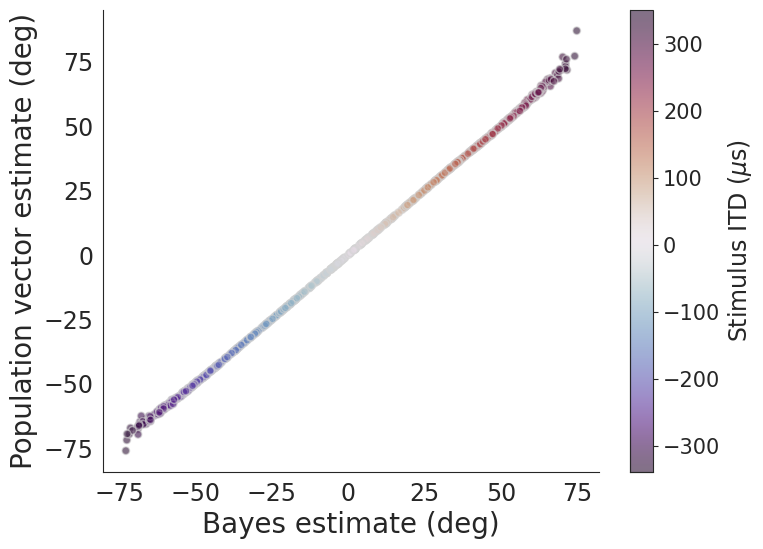

In [ ]:
plot_single_trial_estimates(bayes_estimate, pv_estimate, ITD)

plt.xticks(np.arange(-75, 100, 25))
plt.yticks(np.arange(-75, 100, 25))


#plt.savefig("Figure3E.png", dpi=500)
#files.download("Figure3E.png")

plt.show()

Figure 3F

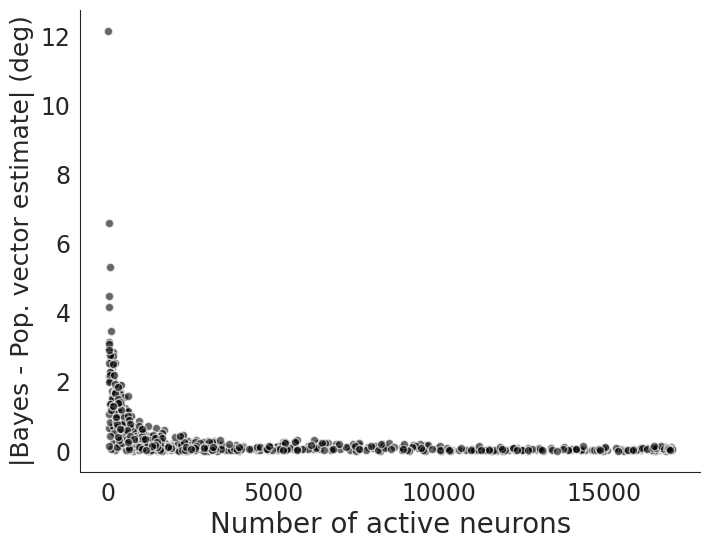

In [ ]:
plot_error_number_active(bayes_estimate, pv_estimate, number_active_neurons)

plt.xticks([0, 5000, 10000, 15000])

#plt.savefig("Figure3F.png", dpi=500)
#files.download("Figure3F.png")

plt.show()

Compute the largest error

In [ ]:
np.max(np.abs(bayes_estimate- pv_estimate))

12.14698629901116

How many neurons are active for errors larger than 10 degrees?

In [ ]:
errors = np.abs(bayes_estimate- pv_estimate)

number_active_neurons[errors > 10]

array([2.])

## Figure 4

We evaluated the performance of the neural decoding at different population sizes, taking into account the effects of random selection of preferred directions from the prior, noise in the mapping from direction to ITD, and Poisson neural noise.

In [ ]:
# Specify the simulation parameters

number_neurons = np.array([10, 50, 100, 500, 1000, 5000, 10000])

number_populations = 5

number_repetitions = 10
stimulus_azimuth = np.linspace(-150, 150, 15)
binaural_correlation = np.array([1])

# Initialize array to hold results
abs_error = np.zeros((len(number_neurons), number_populations, number_repetitions*len(stimulus_azimuth)))

# Run the simulation
np.random.seed(seed=40)
for i, j in enumerate(number_neurons):
    print(j)
    for k in range(number_populations):
        best_azimuth = prior.rvs(size = j.astype(int))

        bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD = run_localization_simulation(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth)

        abs_error[i,k,:] = np.abs(bayes_estimate - pv_estimate).flatten()

10
50
100
500
1000
5000
10000


Create arrays holding the number of neurons (population size) and the absolute errors for plotting

In [ ]:
absolute_error = abs_error.reshape(7, number_populations*150)

X = np.tile(number_neurons.reshape(-1,1), number_populations*150)

Figure 4

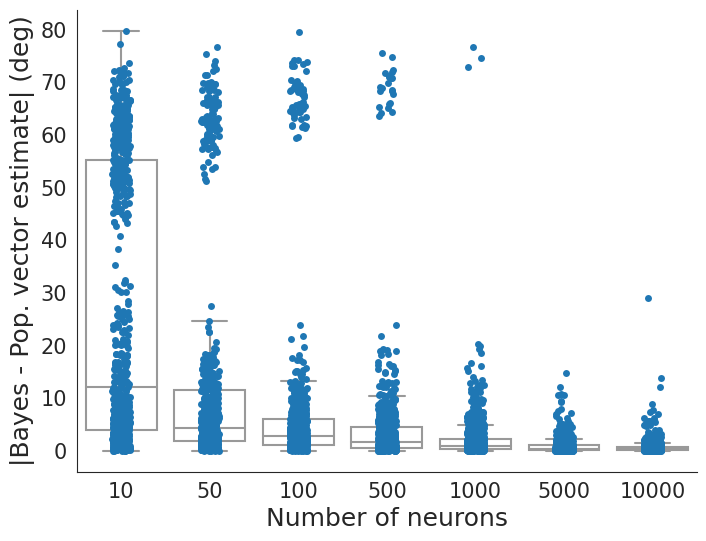

In [ ]:
plt.figure(figsize = (8,6))

sns.boxplot(x = X.flatten(), y = absolute_error.flatten(), color='w', fliersize=0)
sns.stripplot(x = X.flatten(), y = absolute_error.flatten())

plt.tick_params(labelsize = 15)

plt.xlabel('Number of neurons', fontsize = 18)
plt.ylabel('|Bayes - Pop. vector estimate| (deg)', fontsize = 18);

#plt.xticks(np.arange(0,12), labels = number_neurons)

sns.despine(right=True, top=True);

#plt.savefig("Figure4.png", dpi=500)
#files.download("Figure4.png")

plt.show()

Display the median errors to check that they are decreasing as the population size increases

In [ ]:
np.median(absolute_error, axis=1)

array([12.06353224,  4.37037703,  2.72944094,  1.6047    ,  0.86444912,
        0.4030861 ,  0.26040607])

## Figure 5

We simulated the manipulation of the reliability of ITD by varying BC using a non-mechanistic model where the standard deviation of the noise corrupting ITD depends on BC.

Figure 5A

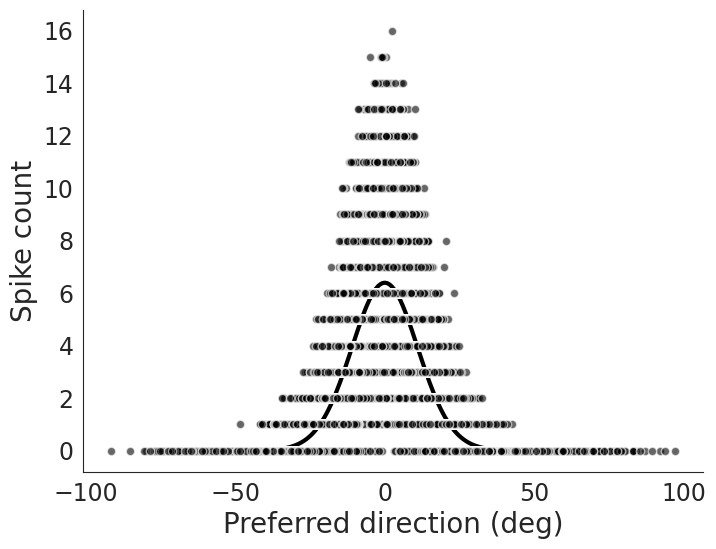

In [ ]:
plot_likelihood_population_response(best_azimuth_large, 1, 0, 0)

#plt.savefig("Figure5A.png", dpi=500)
#files.download("Figure5A.png")

plt.show()

Figure 5B

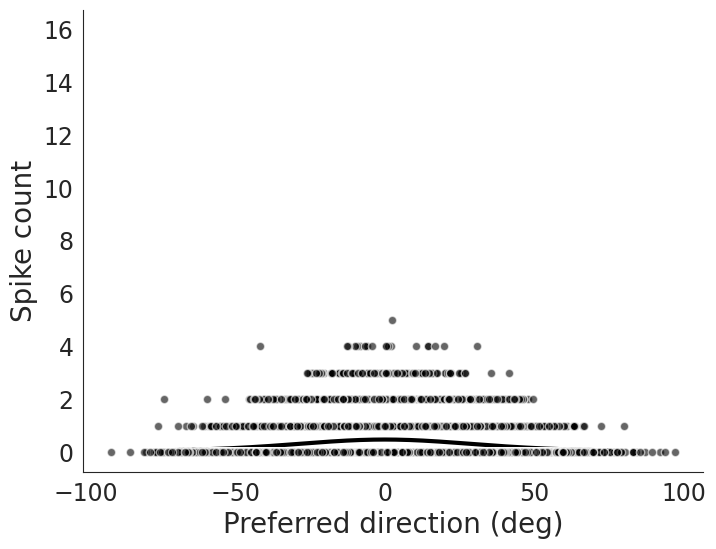

In [ ]:
plot_likelihood_population_response(best_azimuth_large, 0.1, 0, 0)

plt.ylim(-.75, 16.75)

#plt.savefig("Figure5B.png", dpi=500)
#files.download("Figure5B.png")

plt.show()

Run the simulation

In [ ]:
number_repetitions = 50
stimulus_azimuth = np.array([-75, -55, 55, 75])
binaural_correlation = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0])

np.random.seed(seed=0)
bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD = run_localization_simulation(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth_large)

Figure 5C

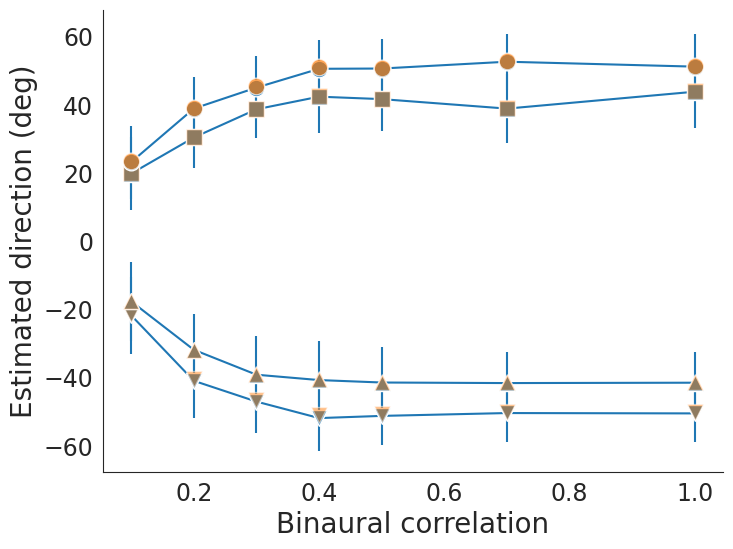

In [ ]:
plt.figure(figsize=(8,6))

n = 0
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4', marker = 'v', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e',  marker = 'v', ms = 12, linewidth = 0, alpha = 0.5, mec = 'w')


n = 1
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4', marker = '^', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e', marker = '^', ms = 12, linewidth = 0, alpha = 0.5, mec = 'w')

n = 2
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4',  marker = 's', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e',  marker = 's', ms = 12, linewidth = 0, alpha = 0.5, mec = 'w')

n = 3
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4', marker = 'o', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e',  marker = 'o', ms = 12, linewidth = 0, alpha = 0.7, mec = 'w')


plt.tick_params(labelsize = 17)

plt.xlabel('Binaural correlation', fontsize = 20)
plt.ylabel('Estimated direction (deg)', fontsize = 20);

sns.despine(right=True, top=True);


#plt.savefig("Figure5C.png", dpi=500)
#files.download("Figure5C.png")

plt.show()


Figure 5E

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

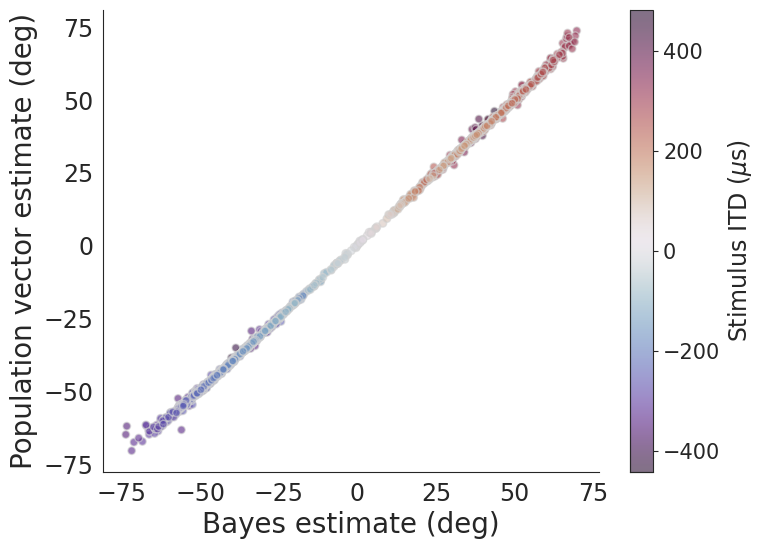

In [ ]:
plot_single_trial_estimates(bayes_estimate, pv_estimate, ITD)

plt.xticks(np.arange(-75, 100, 25))
plt.yticks(np.arange(-75, 100, 25))


plt.savefig("Figure5E.png", dpi=500)
files.download("Figure5E.png")

plt.show()

Figure 5F

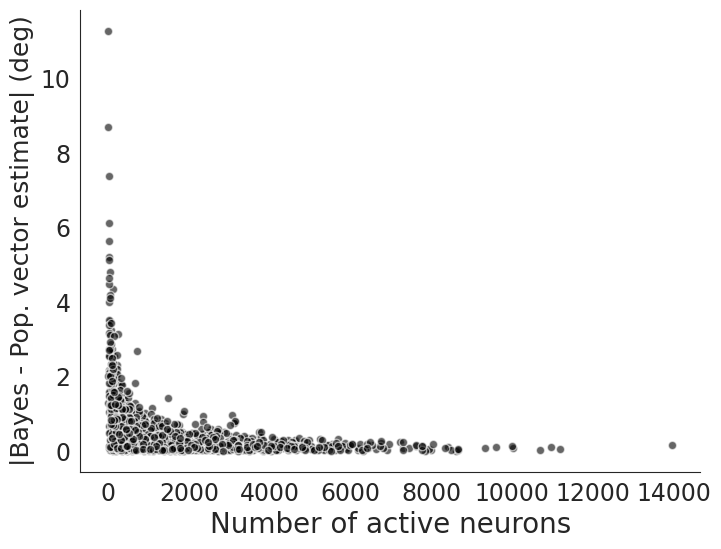

In [ ]:
plot_error_number_active(bayes_estimate.flatten(), pv_estimate.flatten(), number_active_neurons.flatten())

#plt.savefig("Figure5F.png", dpi=500)
#files.download("Figure5F.png")

plt.show()

## Supplementary Figure

We show how changing the gain of responses can effectively change the prior.

In [ ]:
def get_pv_bayes_change_prior(azimuth, binaural_correlation, best_azimuth, A, w, sigma_ITD, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new):
    """
    This function takes a stimulus azimuth as input, produces a noisy stimulus ITD,
    and computes the Bayesian and population vector estimates of direction.
    """


    max_rate = 4.9 * binaural_correlation**2 + 1.2 * binaural_correlation + 0.3

    # Generate the stimulus ITD with standard deviation depending on binaural correlation
    itd_standard_deviation = sigma_ITD + 219.34*np.exp(-11.31 * binaural_correlation)


    # Generate a noisy ITD observation
    ITD = A * np.sin(w * azimuth) + stats.norm(loc = 0, scale = itd_standard_deviation).rvs()

    # Set up components of Bayesian decoder: (1) x, y components of unit vectors in all directions
    #                                        (2) prior
    #                                        (3) ITD at each direction


    # Bayes model
    direction = np.linspace(-180, 180, 1000)
    d_dir = direction[1] - direction[0]
    x = np.cos(direction * np.pi / 180)
    y = np.sin(direction * np.pi / 180)

    mean_itd = A * np.sin(w * direction)

    prior_old = stats.norm(loc = mu_prior_old, scale = sigma_prior_old).pdf(direction)

    prior_new = stats.norm(loc = mu_prior_new, scale = sigma_prior_new).pdf(direction)

    likelihood = stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(mean_itd)

    posterior = prior_new * likelihood / np.sum(prior_new * likelihood * d_dir)

    mean_x_component = np.sum(x * posterior) * d_dir

    mean_y_component = np.sum(y * posterior) * d_dir

    bayes_estimate = math.atan2(mean_y_component, mean_x_component) * 180 / np.pi


    # PV

    best_itd = A * np.sin(w * best_azimuth)

    gain = stats.norm(loc = mu_prior_new, scale = sigma_prior_new).pdf(best_azimuth) / stats.norm(loc = mu_prior_old, scale = sigma_prior_old).pdf(best_azimuth)

    population_rate = max_rate * gain * stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(best_itd) * np.sqrt(2 * np.pi) * sigma_ITD

    population_response = stats.poisson(mu = population_rate).rvs()

    x_pv = np.cos(best_azimuth * np.pi / 180)
    y_pv = np.sin(best_azimuth * np.pi / 180)

    mean_x = np.sum(x_pv * population_response)

    mean_y = np.sum(y_pv * population_response)

    pv_estimate = math.atan2(mean_y, mean_x) * 180 / np.pi

    # Response rates
    num_active = np.sum([population_response >= 1])

    num_spikes = np.sum(population_response)


    return bayes_estimate, pv_estimate, num_active, num_spikes, ITD

In [ ]:
def run_localization_simulation_change_prior(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new):

    # Get the number of stimulus conditions
    number_azimuths = np.size(stimulus_azimuth)
    number_bcs = np.size(binaural_correlation)

    # Initialize arrays to store the results
    pv_estimate = np.zeros((number_azimuths, number_bcs, number_repetitions))
    bayes_estimate = np.zeros((number_azimuths, number_bcs, number_repetitions))
    number_active_neurons = np.zeros((number_azimuths, number_bcs, number_repetitions))
    number_spikes = np.zeros((number_azimuths, number_bcs, number_repetitions))
    ITD = np.zeros((number_azimuths, number_bcs, number_repetitions))

    for i, azimuth in enumerate(stimulus_azimuth):
        for j, bc in enumerate(binaural_correlation):
            for k in range(number_repetitions):

                bayes_estimate[i, j, k], pv_estimate[i, j, k], number_active_neurons[i, j, k], number_spikes[i, j, k], ITD[i, j, k] = get_pv_bayes_change_prior(azimuth, bc, best_azimuth, A, w, sigma_ITD, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)


    # Squeeze results to remove singleton dimensions
    pv_estimate = np.squeeze(pv_estimate)
    bayes_estimate = np.squeeze(bayes_estimate)
    number_active_neurons = np.squeeze(number_active_neurons)
    number_spikes = np.squeeze(number_spikes)

    abs_errror = np.abs(bayes_estimate - pv_estimate)

    number_dimensions = bayes_estimate.ndim

    mean_bayes_estimate = np.mean(bayes_estimate, number_dimensions-1)
    mean_pv_estimate = np.mean(pv_estimate, number_dimensions-1)

    sd_bayes_estimate = np.std(bayes_estimate, number_dimensions-1, ddof = 1)
    sd_pv_estimate = np.std(pv_estimate, number_dimensions-1, ddof = 1)

    return bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD


Function to plot old and new prior

In [ ]:
def plot_prior_change(preferred_directions, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new):
    """
    This function plots the Gaussian prior and a histogram of the perferred directions
    """
    plt.figure(figsize = (8,6))

    # Plot the histogram of the preferred directions
    sns.histplot(preferred_directions, stat = 'density', alpha = 0.6, color = 'k')

    # Plot the pdf for the prior
    prior = stats.norm(loc = mu_prior_old, scale = sigma_prior_old)

    x_bound = np.max([prior.ppf(0.9995),np.max(np.abs(preferred_directions))])
    x_p = np.arange(-x_bound, x_bound)

    plt.plot(x_p, prior.pdf(x_p), 'k', linewidth=3)

    # Plot the pdf for the new prior
    prior = stats.norm(loc = mu_prior_new, scale = sigma_prior_new);

    #x_bound = np.max([prior.ppf(0.9995),np.max(np.abs(preferred_directions))])
    #x_p = np.arange(-x_bound, x_bound)

    plt.plot(x_p, prior.pdf(x_p), 'b', linewidth=3)

    # Formatting
    if mu_prior_new < 0:
      plt.legend(['Original prior', 'New prior', 'Preferred directions'], loc = 'upper right', fontsize = 14, frameon=False)
    else:
      plt.legend(['Original prior', 'New prior', 'Preferred directions'], loc = 'upper left', fontsize = 14, frameon=False)

    plt.tick_params(labelsize = 17)

    plt.xlabel('Direction (deg)', fontsize = 20)
    plt.ylabel('Density', fontsize = 20)

    sns.despine(right=True, top=True)

In [ ]:
def plot_gain(preferred_directions, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new):
    """
    This function plots the gain required to change the prior
    """
    plt.figure(figsize = (8,6))

    gain = stats.norm(loc = mu_prior_new, scale = sigma_prior_new).pdf(preferred_directions) / stats.norm(loc = mu_prior_old, scale = sigma_prior_old).pdf(preferred_directions)

    plt.plot(preferred_directions, gain,'ko', alpha = 0.6, mec = 'w', ms=6);

    plt.tick_params(labelsize = 17)

    plt.xlabel('Preferred direction (deg)', fontsize = 20)
    plt.ylabel('Firing rate gain', fontsize = 20)

    sns.despine(right=True, top=True)

In [ ]:
def plot_likelihood_population_response_gain(preferred_directions, binaural_correlation, ITD, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new, random_seed=0):

    """
    Plot the likelihood function and the population response spike counts for an ITD and BC with gain to shift prior
    """

    gain = stats.norm(loc = mu_prior_new, scale = sigma_prior_new).pdf(preferred_directions) / stats.norm(loc = mu_prior_old, scale = sigma_prior_old).pdf(preferred_directions)


    max_rate = 4.9 * binaural_correlation**2 + 1.2 * binaural_correlation + 0.3

    # Generate the stimulus ITD with standard deviation depending on binaural correlation
    itd_standard_deviation = sigma_ITD + 219.34*np.exp(-11.31 * binaural_correlation)

    # model neural population response
    best_itd = A * np.sin(w * preferred_directions)
    population_rate = max_rate * gain * stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(best_itd) * np.sqrt(2 * np.pi) * itd_standard_deviation
    np.random.seed(seed=random_seed)
    population_response = stats.poisson(mu = population_rate).rvs()

    # Likelihood
    x = np.linspace(-75, 75, 201)
    likelihood = max_rate * stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(A * np.sin(w * x)) * np.sqrt(2 * np.pi) * itd_standard_deviation

    # Plot
    plt.figure(figsize = (8,6))

    plt.plot(x, likelihood, 'k', linewidth=3)

    plt.plot(preferred_directions, population_response,'ko', alpha = 0.6, mec = 'w', ms=6);

    plt.tick_params(labelsize = 17)

    plt.xlabel('Preferred direction (deg)', fontsize = 20)
    plt.ylabel('Spike count', fontsize = 20)

    sns.despine(right=True, top=True)

### Shift prior to the left

Run the simulation

In [ ]:
mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new = 0, sigma_prior, -30, sigma_prior

number_repetitions = 50
stimulus_azimuth = np.linspace(-150, 150, 15)
binaural_correlation = np.array([1])

np.random.seed(seed=100)

bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD = run_localization_simulation_change_prior(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

Plot the trial average estimates

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

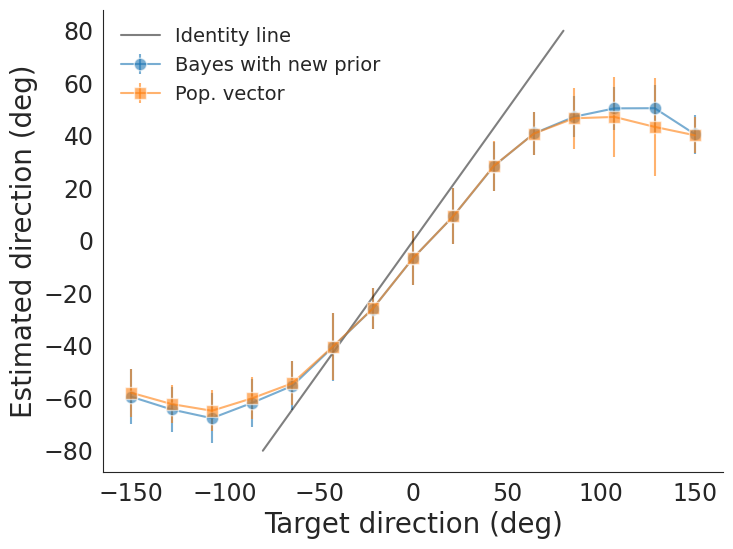

In [ ]:
plot_trial_average_estimates(stimulus_azimuth,
                             mean_bayes_estimate,
                             sd_bayes_estimate,
                             mean_pv_estimate,
                             sd_pv_estimate)

plt.plot([-80, 80], [-80, 80], 'k', alpha=0.5)


plt.legend(['Identity line', 'Bayes with new prior', 'Pop. vector'], loc = 'upper left', fontsize = 14, frameon=False);


#plt.savefig("FigureSD.png", dpi=500)
#files.download("FigureSD.png")

plt.show()

Plot the single trial estimates

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

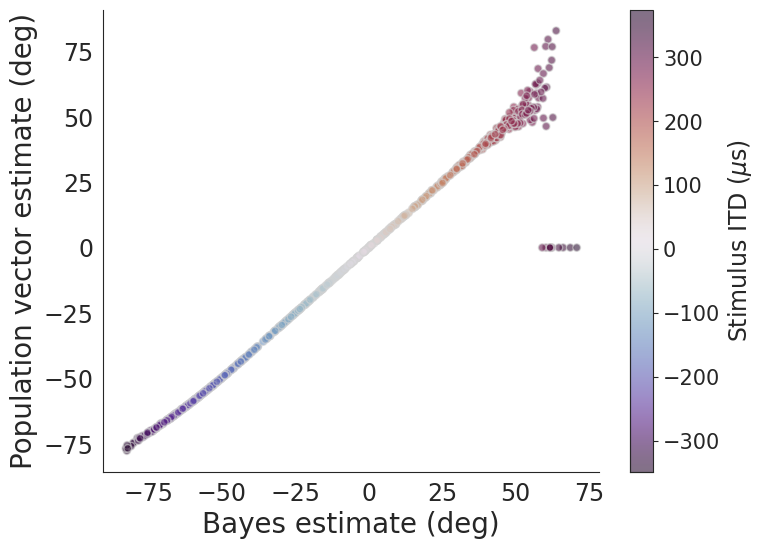

In [ ]:
plot_single_trial_estimates(bayes_estimate, pv_estimate, ITD)

plt.xticks(np.arange(-75, 100, 25))
plt.yticks(np.arange(-75, 100, 25))

#plt.savefig("FigureSE.png", dpi=500)
#files.download("FigureSE.png")

plt.show()


Plot the old and new prior

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

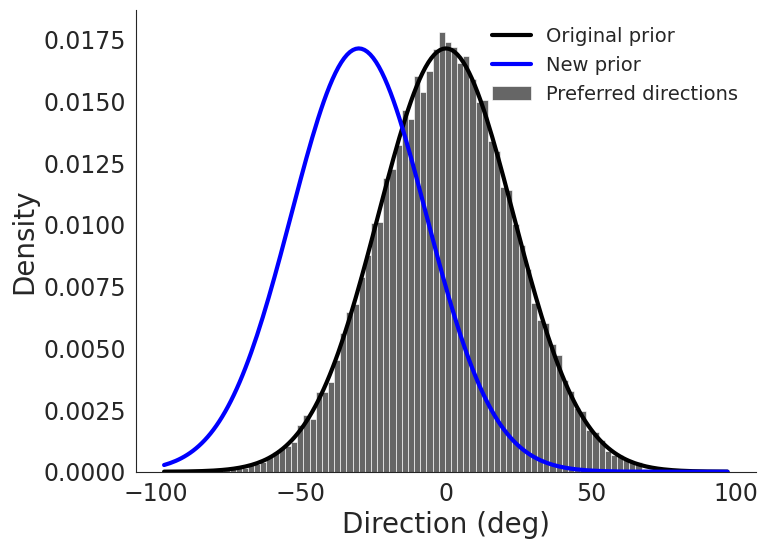

In [ ]:
plot_prior_change(best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

#plt.savefig("FigureSA.png", dpi=500)
#files.download("FigureSA.png")

plt.show()

Plot the gain required to change the prior

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

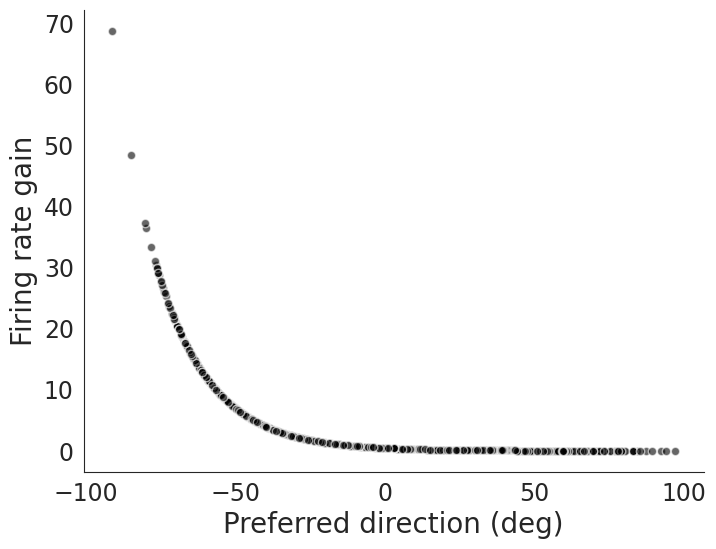

In [ ]:
plot_gain(best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

#plt.savefig("FigureSB.png", dpi=500)
#files.download("FigureSB.png")

plt.show()

Plot the gain-modulated activity, compared to the likelihood

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

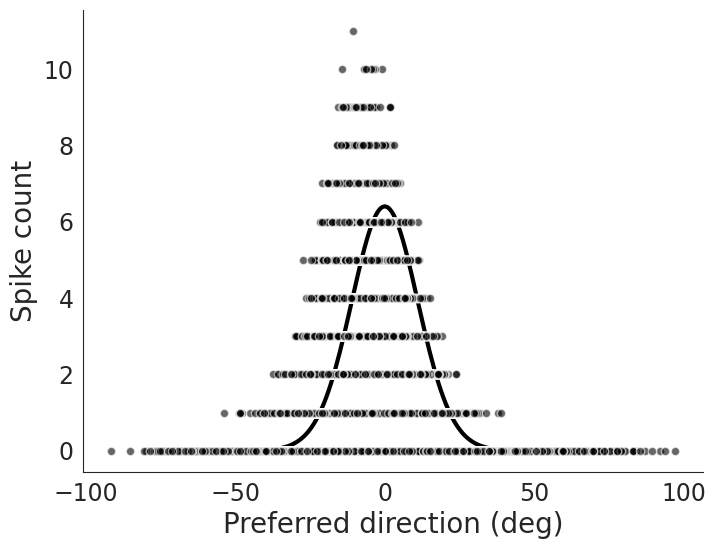

In [ ]:
binaural_correlation = 1
ITD = 0

plot_likelihood_population_response_gain(best_azimuth_large, binaural_correlation, ITD, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new, random_seed=0)

#plt.savefig("FigureSC.png", dpi=500)
#files.download("FigureSC.png")

plt.show()

### Shift prior to the right

Run the simulation

In [ ]:
mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new = 0, sigma_prior, 30, sigma_prior

number_repetitions = 50
stimulus_azimuth = np.linspace(-150, 150, 15)
binaural_correlation = np.array([1])

np.random.seed(seed=100)

bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD = run_localization_simulation_change_prior(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

Plot the trial average estimates

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

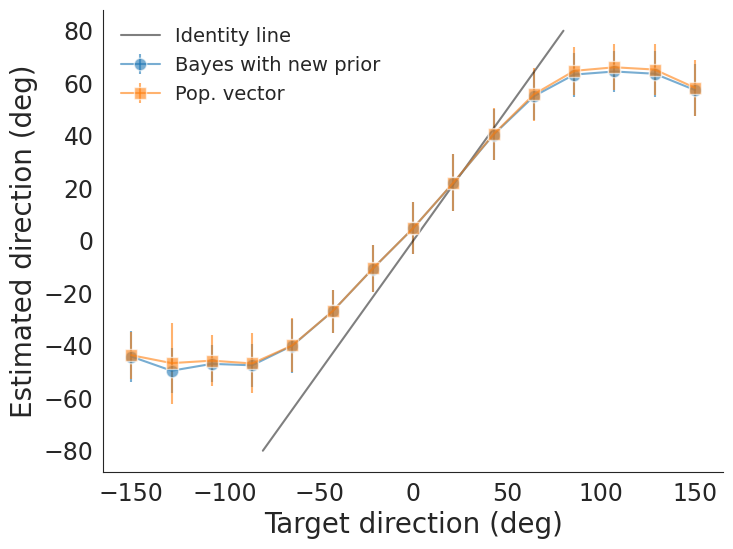

In [ ]:
plot_trial_average_estimates(stimulus_azimuth,
                             mean_bayes_estimate,
                             sd_bayes_estimate,
                             mean_pv_estimate,
                             sd_pv_estimate)

plt.plot([-80, 80], [-80, 80], 'k', alpha=0.5)


plt.legend(['Identity line', 'Bayes with new prior', 'Pop. vector'], loc = 'upper left', fontsize = 14, frameon=False);


#plt.savefig("FigureSI.png", dpi=500); files.download("FigureSI.png")

plt.show()

Plot the single trial estimates

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

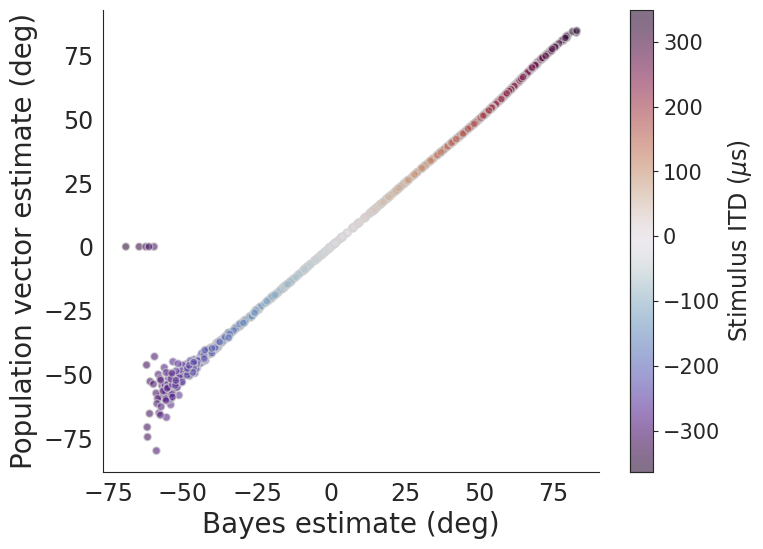

In [ ]:
plot_single_trial_estimates(bayes_estimate, pv_estimate, ITD)

plt.xticks(np.arange(-75, 100, 25))
plt.yticks(np.arange(-75, 100, 25))

#plt.savefig("FigureSJ.png", dpi=500); files.download("FigureSJ.png")

plt.show()


Plot the old and new prior

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

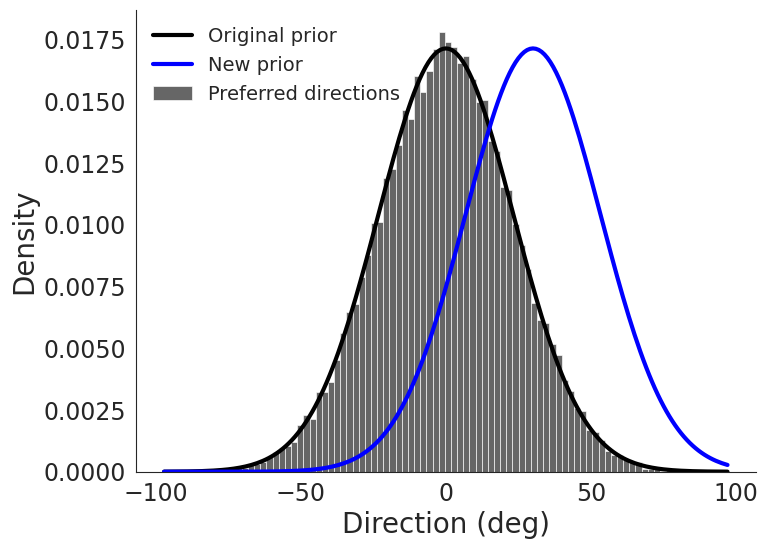

In [ ]:
plot_prior_change(best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

#plt.savefig("FigureSF.png", dpi=500); files.download("FigureSF.png")

plt.show()

Plot the gain required to change the prior

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

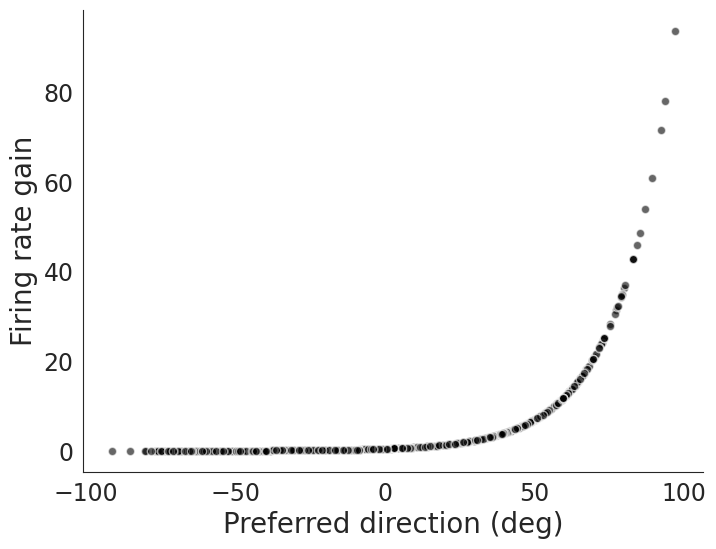

In [ ]:
plot_gain(best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

#plt.savefig("FigureSG.png", dpi=500); files.download("FigureSG.png")

plt.show()

Plot the gain-modulated activity, compared to the likelihood

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

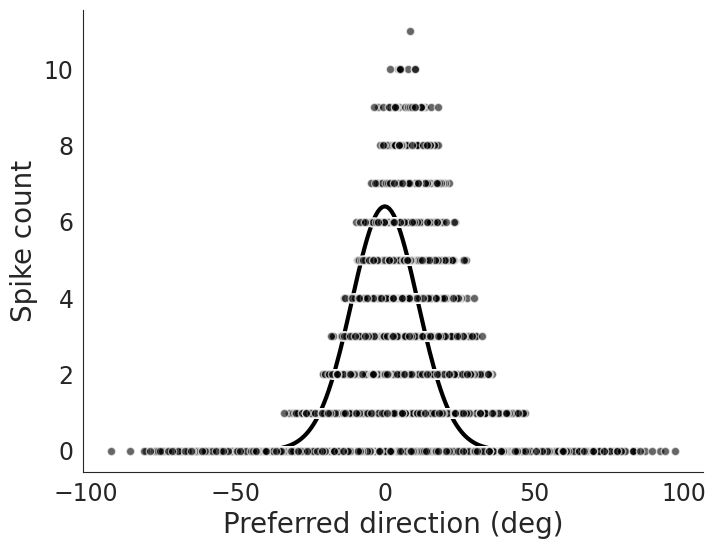

In [ ]:
binaural_correlation = 1
ITD = 0

plot_likelihood_population_response_gain(best_azimuth_large, binaural_correlation, ITD, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new, random_seed=0)

#plt.savefig("FigureSH.png", dpi=500); files.download("FigureSH.png")

plt.show()

### Wider prior

Run the simulation

In [ ]:
mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new = 0, sigma_prior, 0, 35

number_repetitions = 50
stimulus_azimuth = np.linspace(-150, 150, 15)
binaural_correlation = np.array([1])

np.random.seed(seed=100)

bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD = run_localization_simulation_change_prior(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

Plot the trial average estimates

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

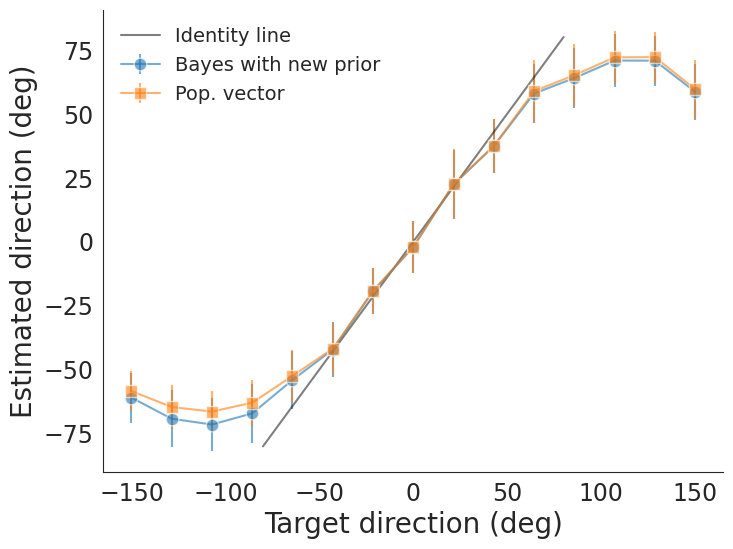

In [ ]:
plot_trial_average_estimates(stimulus_azimuth,
                             mean_bayes_estimate,
                             sd_bayes_estimate,
                             mean_pv_estimate,
                             sd_pv_estimate)

plt.plot([-80, 80], [-80, 80], 'k', alpha=0.5)


plt.legend(['Identity line', 'Bayes with new prior', 'Pop. vector'], loc = 'upper left', fontsize = 14, frameon=False);


#plt.savefig("FigureSN.png", dpi=500); files.download("FigureSN.png")

plt.show()

Plot the single trial estimates

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

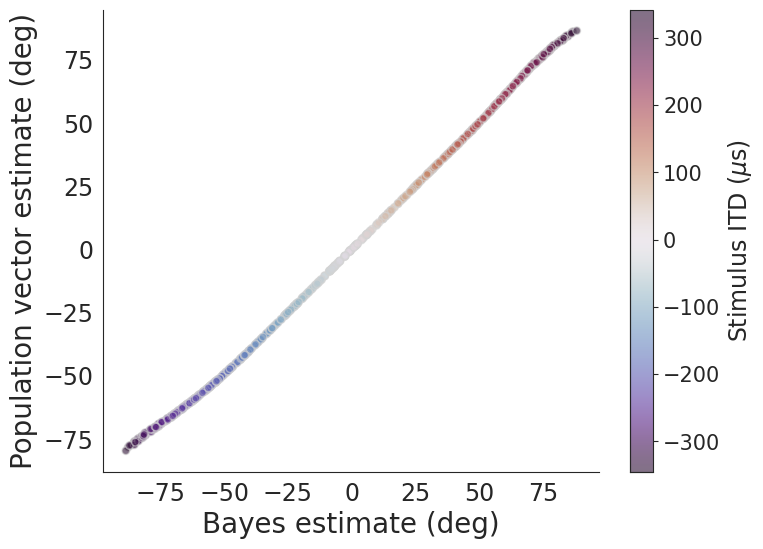

In [ ]:
plot_single_trial_estimates(bayes_estimate, pv_estimate, ITD)

plt.xticks(np.arange(-75, 100, 25))
plt.yticks(np.arange(-75, 100, 25))

#plt.savefig("FigureSO.png", dpi=500); files.download("FigureSO.png")

plt.show()


Plot the old and new prior

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

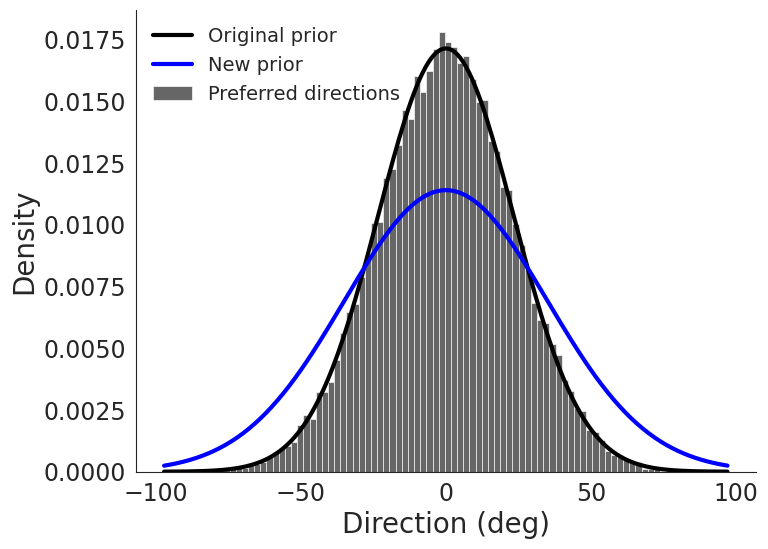

In [ ]:
plot_prior_change(best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

#plt.savefig("FigureSK.png", dpi=500); files.download("FigureSK.png")

plt.show()

Plot the gain required to change the prior

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

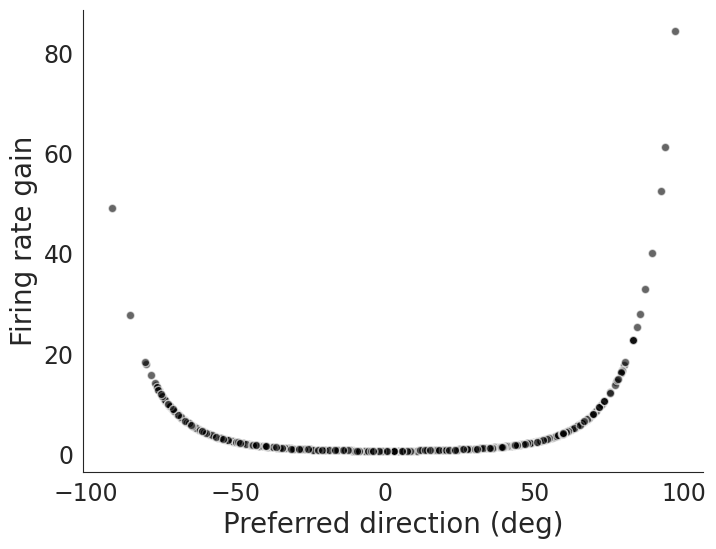

In [ ]:
plot_gain(best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

#plt.savefig("FigureSL.png", dpi=500); files.download("FigureSL.png")

plt.show()

Plot the gain-modulated activity, compared to the likelihood

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

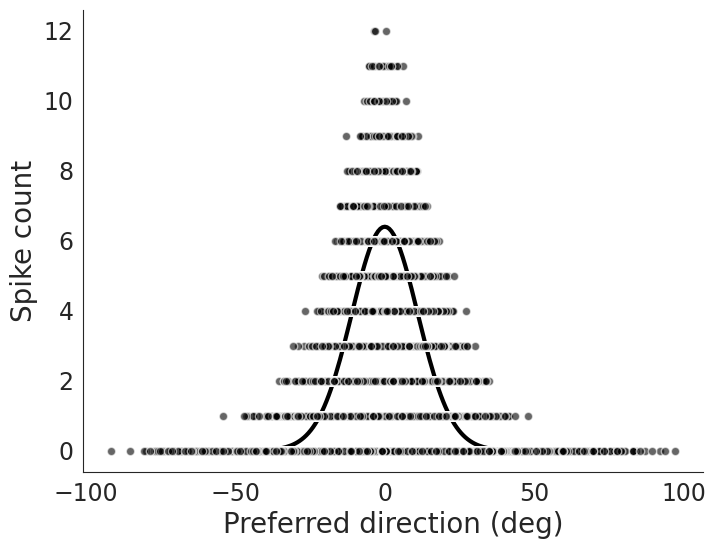

In [ ]:
binaural_correlation = 1
ITD = 0

plot_likelihood_population_response_gain(best_azimuth_large, binaural_correlation, ITD, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new, random_seed=0)

#plt.savefig("FigureSM.png", dpi=500); files.download("FigureSM.png")

plt.show()

### Narrower prior

Run the simulation

In [ ]:
mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new = 0, sigma_prior, 0, 15

number_repetitions = 50
stimulus_azimuth = np.linspace(-150, 150, 15)
binaural_correlation = np.array([1])

np.random.seed(seed=100)

bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD = run_localization_simulation_change_prior(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

Plot the trial average estimates

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

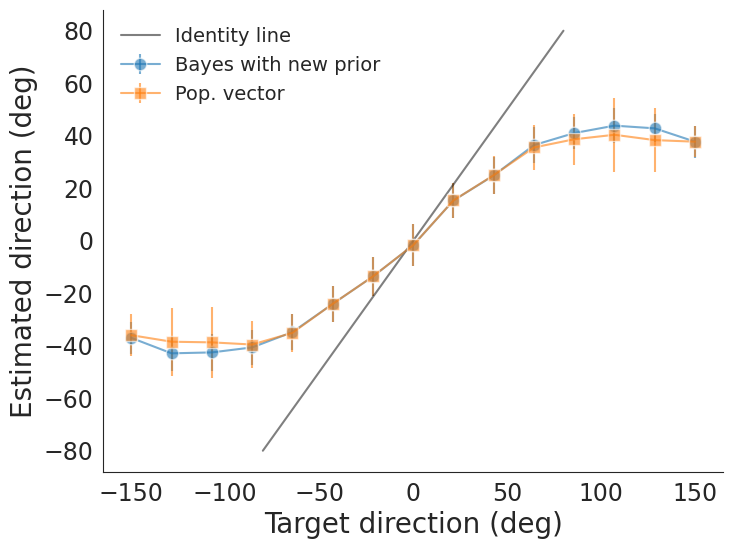

In [ ]:
plot_trial_average_estimates(stimulus_azimuth,
                             mean_bayes_estimate,
                             sd_bayes_estimate,
                             mean_pv_estimate,
                             sd_pv_estimate)

plt.plot([-80, 80], [-80, 80], 'k', alpha=0.5)


plt.legend(['Identity line', 'Bayes with new prior', 'Pop. vector'], loc = 'upper left', fontsize = 14, frameon=False);


#plt.savefig("FigureSS.png", dpi=500); files.download("FigureSS.png")

plt.show()

Plot the single trial estimates

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

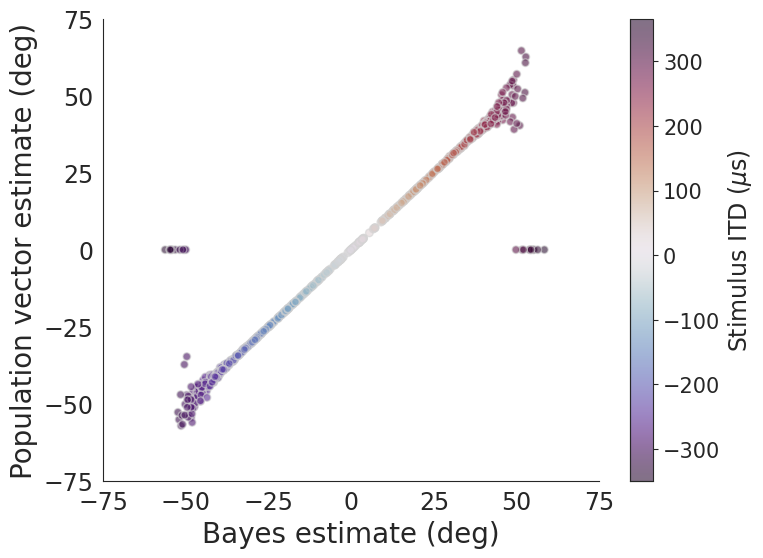

In [ ]:
plot_single_trial_estimates(bayes_estimate, pv_estimate, ITD)

plt.xticks(np.arange(-75, 100, 25))
plt.yticks(np.arange(-75, 100, 25))

#plt.savefig("FigureST.png", dpi=500); files.download("FigureST.png")

plt.show()


Plot the old and new prior

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

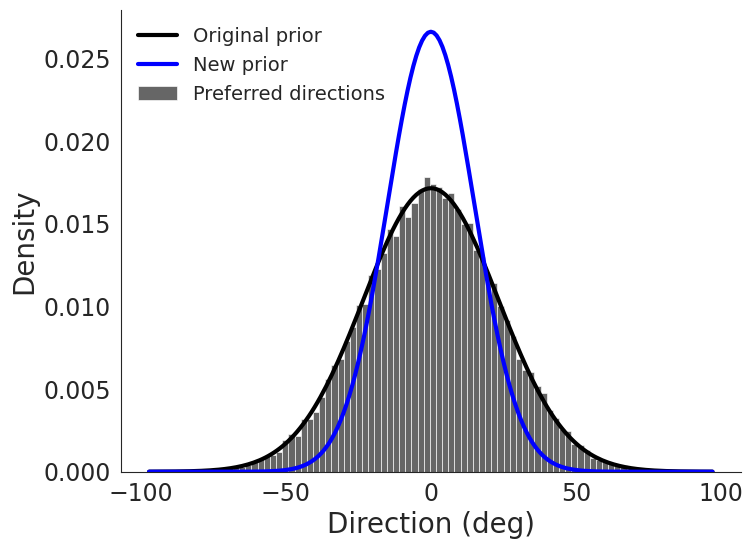

In [ ]:
plot_prior_change(best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

#plt.savefig("FigureSP.png", dpi=500); files.download("FigureSP.png")

plt.show()

Plot the gain required to change the prior

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

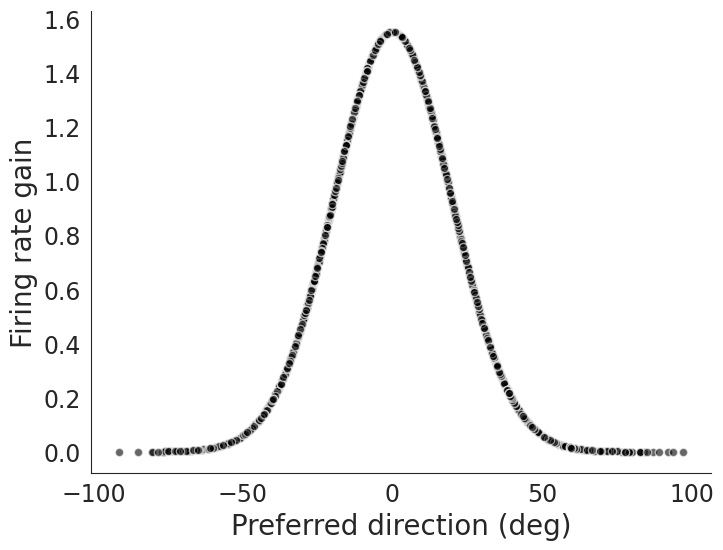

In [ ]:
plot_gain(best_azimuth_large, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new)

plt.savefig("FigureSQ.png", dpi=500); files.download("FigureSQ.png")

plt.show()

Plot the gain-modulated activity, compared to the likelihood

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

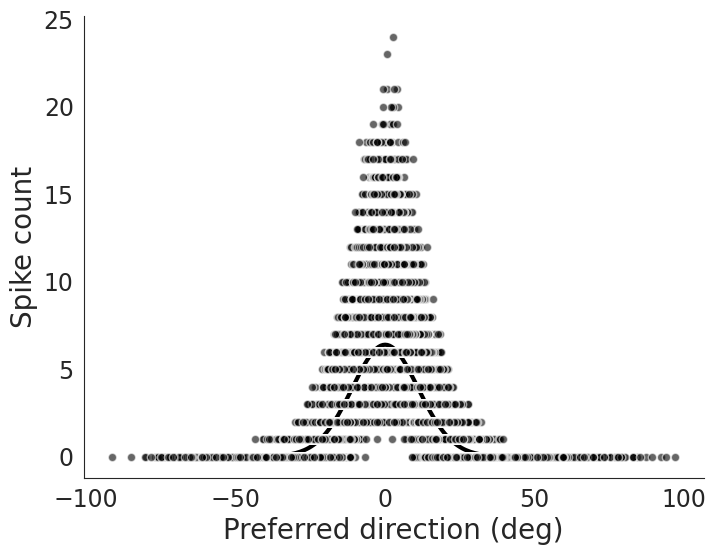

In [ ]:
binaural_correlation = 1
ITD = 0

plot_likelihood_population_response_gain(best_azimuth_large, binaural_correlation, ITD, mu_prior_old, sigma_prior_old, mu_prior_new, sigma_prior_new, random_seed=0)

#plt.savefig("FigureSR.png", dpi=500); files.download("FigureSR.png")

plt.show()

### Supplementary figure with constant max firing rate

In [ ]:
def get_pv_bayes_max_rate(azimuth, binaural_correlation, best_azimuth, A, w, sigma_ITD, max_rate):
    """
    This function takes a stimulus azimuth as input, produces a noisy stimulus ITD,
    and computes the Bayesian and population vector estimates of direction.
    """

    # Keep the maximum firing rate constant relative to BC
    #max_rate = 6.4

    # Generate the stimulus ITD with standard deviation depending on binaural correlation
    itd_standard_deviation = sigma_ITD + 219.34*np.exp(-11.31 * binaural_correlation)


    # Generate a noisy ITD observation
    ITD = A * np.sin(w * azimuth) + stats.norm(loc = 0, scale = itd_standard_deviation).rvs()

    # Set up components of Bayesian decoder: (1) x, y components of unit vectors in all directions
    #                                        (2) prior
    #                                        (3) ITD at each direction


    # Bayes model
    direction = np.linspace(-180, 180, 1000)
    d_dir = direction[1] - direction[0]
    x = np.cos(direction * np.pi / 180)
    y = np.sin(direction * np.pi / 180)

    mean_itd = A * np.sin(w * direction)

    prior = stats.norm(loc = 0, scale = sigma_prior).pdf(direction)

    likelihood = stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(mean_itd)

    posterior = prior * likelihood / np.sum(prior * likelihood * d_dir)

    mean_x_component = np.sum(x * posterior) * d_dir

    mean_y_component = np.sum(y * posterior) * d_dir

    bayes_estimate = math.atan2(mean_y_component, mean_x_component) * 180 / np.pi


    # PV

    best_itd = A * np.sin(w * best_azimuth)

    population_rate = max_rate * stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(best_itd) * np.sqrt(2 * np.pi) * sigma_ITD

    population_response = stats.poisson(mu = population_rate).rvs()

    x_pv = np.cos(best_azimuth * np.pi / 180)
    y_pv = np.sin(best_azimuth * np.pi / 180)

    mean_x = np.sum(x_pv * population_response)

    mean_y = np.sum(y_pv * population_response)

    pv_estimate = math.atan2(mean_y, mean_x) * 180 / np.pi

    # Response rates
    num_active = np.sum([population_response >= 1])

    num_spikes = np.sum(population_response)


    return bayes_estimate, pv_estimate, num_active, num_spikes, ITD

In [ ]:
def run_localization_simulation_max_rate(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth, max_rate):

    # Get the number of stimulus conditions
    number_azimuths = np.size(stimulus_azimuth)
    number_bcs = np.size(binaural_correlation)

    # Initialize arrays to store the results
    pv_estimate = np.zeros((number_azimuths, number_bcs, number_repetitions))
    bayes_estimate = np.zeros((number_azimuths, number_bcs, number_repetitions))
    number_active_neurons = np.zeros((number_azimuths, number_bcs, number_repetitions))
    number_spikes = np.zeros((number_azimuths, number_bcs, number_repetitions))
    ITD = np.zeros((number_azimuths, number_bcs, number_repetitions))

    for i, azimuth in enumerate(stimulus_azimuth):
        for j, bc in enumerate(binaural_correlation):
            for k in range(number_repetitions):

                bayes_estimate[i, j, k], pv_estimate[i, j, k], number_active_neurons[i, j, k], number_spikes[i, j, k], ITD[i, j, k] = get_pv_bayes_max_rate(azimuth, bc, best_azimuth, A, w, sigma_ITD, max_rate)


    # Squeeze results to remove singleton dimensions
    pv_estimate = np.squeeze(pv_estimate)
    bayes_estimate = np.squeeze(bayes_estimate)
    number_active_neurons = np.squeeze(number_active_neurons)
    number_spikes = np.squeeze(number_spikes)

    abs_errror = np.abs(bayes_estimate - pv_estimate)

    number_dimensions = bayes_estimate.ndim

    mean_bayes_estimate = np.mean(bayes_estimate, number_dimensions-1)
    mean_pv_estimate = np.mean(pv_estimate, number_dimensions-1)

    sd_bayes_estimate = np.std(bayes_estimate, number_dimensions-1, ddof = 1)
    sd_pv_estimate = np.std(pv_estimate, number_dimensions-1, ddof = 1)

    return bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD


In [ ]:
def plot_likelihood_population_response_max_rate(preferred_directions, binaural_correlation, ITD, max_rate, random_seed=0):

    """
    Plot the likelihood function and the population response spike counts for an ITD and BC
    """

    #max_rate = 6.4

    # Generate the stimulus ITD with standard deviation depending on binaural correlation
    itd_standard_deviation = sigma_ITD + 219.34*np.exp(-11.31 * binaural_correlation)

    # model neural population response
    best_itd = A * np.sin(w * preferred_directions)
    population_rate = max_rate * stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(best_itd) * np.sqrt(2 * np.pi) * itd_standard_deviation
    np.random.seed(seed=random_seed)
    population_response = stats.poisson(mu = population_rate).rvs()

    # Likelihood
    max_direction = np.max(np.abs(preferred_directions))
    #x = np.linspace(-75, 75, 201)
    x = np.linspace(-max_direction, max_direction, 201)
    likelihood = max_rate * stats.norm(loc = ITD, scale = itd_standard_deviation).pdf(A * np.sin(w * x)) * np.sqrt(2 * np.pi) * itd_standard_deviation

    # Plot
    plt.figure(figsize = (8,6))

    plt.plot(x, likelihood, 'k', linewidth=3)

    plt.plot(preferred_directions, population_response,'ko', alpha = 0.6, mec = 'w', ms=6);

    plt.tick_params(labelsize = 17)

    plt.xlabel('Preferred direction (deg)', fontsize = 20)
    plt.ylabel('Spike count', fontsize = 20)

    sns.despine(right=True, top=True)

## Supplementary version of Figure 5 with constant firing rates

Create the preferred directions for the 25,000 neuron population.

In [ ]:
N2 = 25_000

prior = stats.norm(loc = 0, scale = sigma_prior)

np.random.seed(seed=1)

best_azimuth_large = prior.rvs(size = N2)

### Supplementary version of Figure 5 with constant high firing rate

We simulated the manipulation of the reliability of ITD by varying BC using a non-mechanistic model where the standard deviation of the noise corrupting ITD depends on BC.

Here the maximum firing rate does not depend on BC. It is held constant at the value that would occur when BC = 1.

In [ ]:
binaural_correlation = 1

max_rate = 4.9 * binaural_correlation**2 + 1.2 * binaural_correlation + 0.3

max_rate

6.4

Figure 5A

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

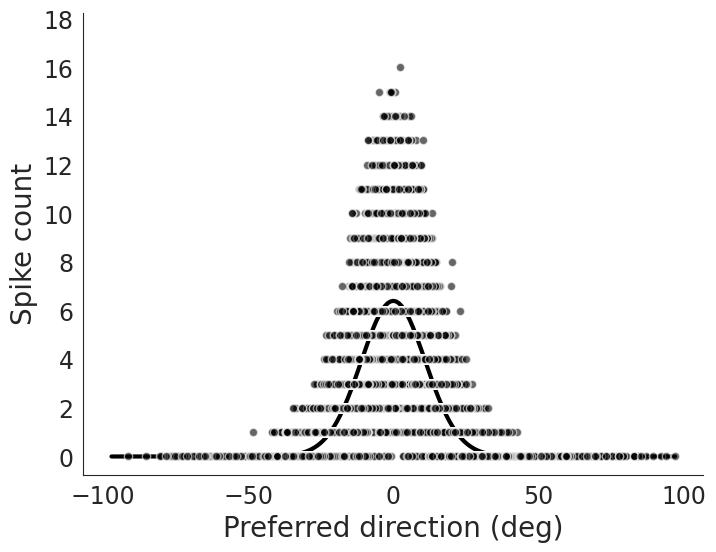

In [ ]:
plot_likelihood_population_response_max_rate(best_azimuth_large, 1, 0, max_rate, 0)
plt.ylim(-.75, 18.25)
plt.yticks(np.arange(0, 20, 2))

plt.savefig("Figure_S2_5A.png", dpi=500)
files.download("Figure_S2_5A.png")

plt.show()

Figure 5B

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

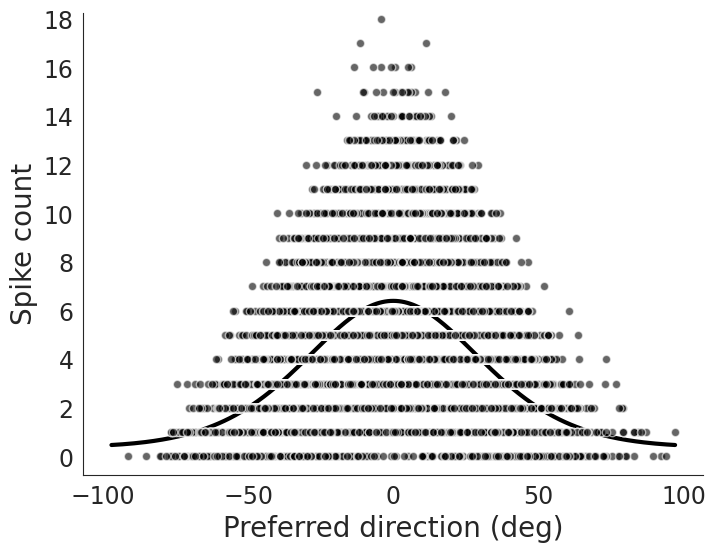

In [ ]:
plot_likelihood_population_response_max_rate(best_azimuth_large, 0.1, 0, max_rate, 0)

plt.ylim(-.75, 18.25)
plt.yticks(np.arange(0, 20, 2))

plt.savefig("Figure_S2_5B.png", dpi=500)
files.download("Figure_S2_5B.png")

plt.show()

Run the simulation

In [ ]:
number_repetitions = 50
stimulus_azimuth = np.array([-75, -55, 55, 75])
binaural_correlation = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0])

np.random.seed(seed=0)
bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD = run_localization_simulation_max_rate(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth_large, max_rate)

Figure 5C

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

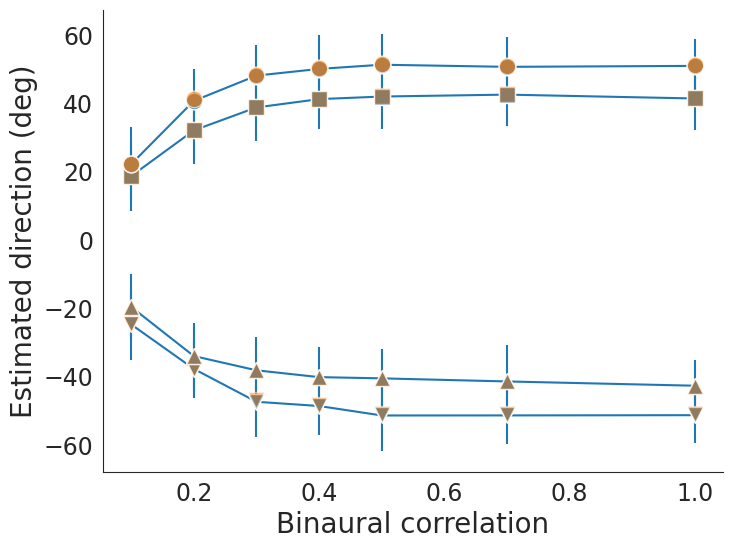

In [ ]:
plt.figure(figsize=(8,6))

n = 0
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4', marker = 'v', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e',  marker = 'v', ms = 12, linewidth = 0, alpha = 0.5, mec = 'w')


n = 1
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4', marker = '^', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e', marker = '^', ms = 12, linewidth = 0, alpha = 0.5, mec = 'w')

n = 2
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4',  marker = 's', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e',  marker = 's', ms = 12, linewidth = 0, alpha = 0.5, mec = 'w')

n = 3
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4', marker = 'o', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e',  marker = 'o', ms = 12, linewidth = 0, alpha = 0.7, mec = 'w')


plt.tick_params(labelsize = 17)

plt.xlabel('Binaural correlation', fontsize = 20)
plt.ylabel('Estimated direction (deg)', fontsize = 20);

sns.despine(right=True, top=True);


plt.savefig("Figure_S2_5C.png", dpi=500)
files.download("Figure_S2_5C.png")

plt.show()


Figure 5E

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

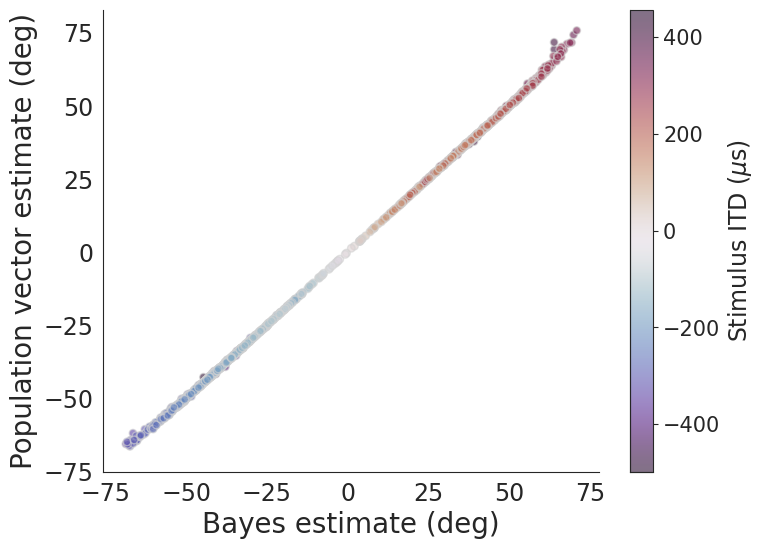

In [ ]:
plot_single_trial_estimates(bayes_estimate, pv_estimate, ITD)

plt.xticks(np.arange(-75, 100, 25))
plt.yticks(np.arange(-75, 100, 25))


plt.savefig("Figure_S2_5E.png", dpi=500)
files.download("Figure_S2_5E.png")

plt.show()

Figure 5F

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

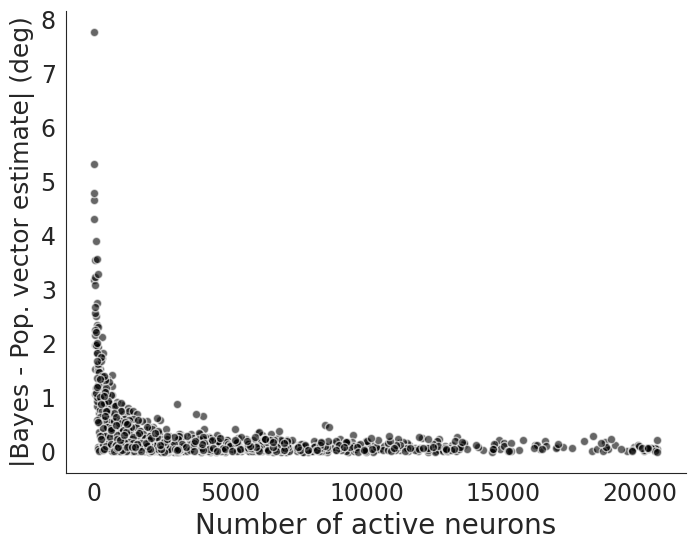

In [ ]:
plot_error_number_active(bayes_estimate.flatten(), pv_estimate.flatten(), number_active_neurons.flatten())

plt.savefig("Figure_S2_5F.png", dpi=500)
files.download("Figure_S2_5F.png")

plt.show()

### Supplementary version of Figure 5 with constant low firing rate

We simulated the manipulation of the reliability of ITD by varying BC using a non-mechanistic model where the standard deviation of the noise corrupting ITD depends on BC.

Here the maximum firing rate does not depend on BC. It is held constant at the value that would occur when BC = 0.1.

In [ ]:
binaural_correlation = 0.1

max_rate = 4.9 * binaural_correlation**2 + 1.2 * binaural_correlation + 0.3

max_rate

0.469

Figure 5A

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

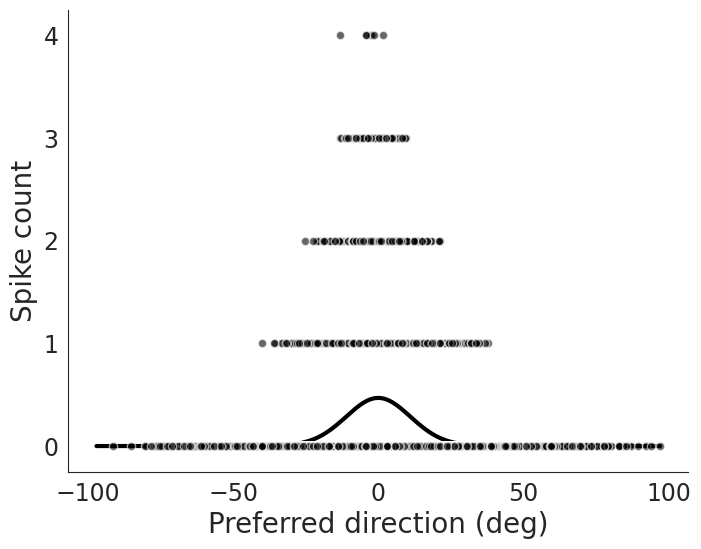

In [ ]:
plot_likelihood_population_response_max_rate(best_azimuth_large, 1, 0, max_rate, 10)
plt.ylim(-.25, 4.25)
plt.yticks(np.arange(0, 5, 1))


plt.savefig("Figure_S3_5A.png", dpi=500)
files.download("Figure_S3_5A.png")

plt.show()

Figure 5B

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

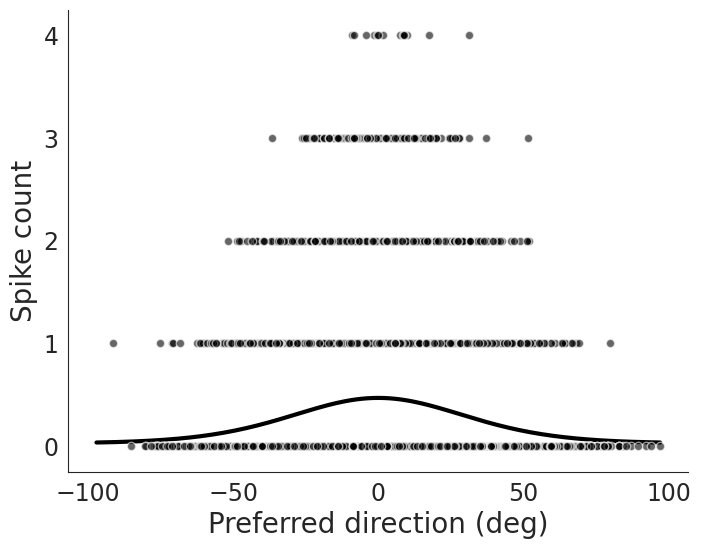

In [ ]:
plot_likelihood_population_response_max_rate(best_azimuth_large, 0.1, 0, max_rate, 10)

plt.ylim(-.25, 4.25)
plt.yticks(np.arange(0, 5, 1))


plt.savefig("Figure_S3_5B.png", dpi=500)
files.download("Figure_S3_5B.png")

plt.show()

Run the simulation

In [ ]:
number_repetitions = 50
stimulus_azimuth = np.array([-75, -55, 55, 75])
binaural_correlation = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0])

np.random.seed(seed=0)
bayes_estimate, pv_estimate, number_active_neurons, number_spikes, mean_bayes_estimate, mean_pv_estimate, sd_bayes_estimate, sd_pv_estimate, ITD = run_localization_simulation_max_rate(stimulus_azimuth, binaural_correlation, number_repetitions, best_azimuth_large, max_rate)

Figure 5C

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

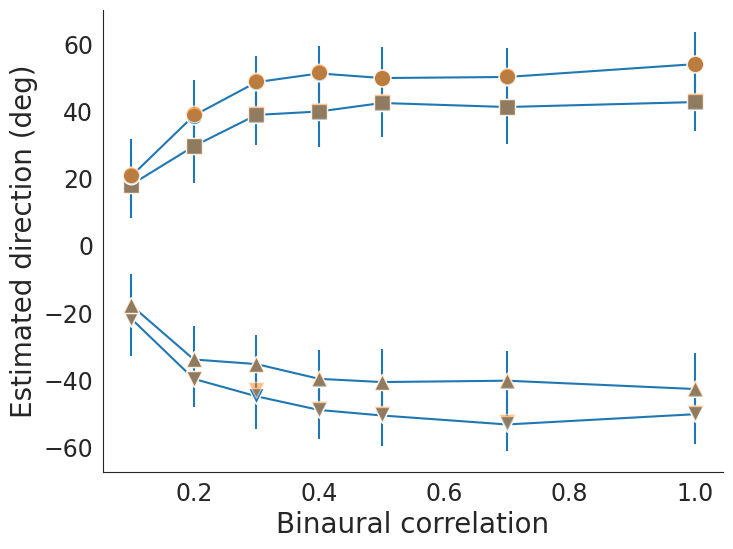

In [ ]:
plt.figure(figsize=(8,6))

n = 0
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4', marker = 'v', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e',  marker = 'v', ms = 12, linewidth = 0, alpha = 0.5, mec = 'w')


n = 1
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4', marker = '^', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e', marker = '^', ms = 12, linewidth = 0, alpha = 0.5, mec = 'w')

n = 2
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4',  marker = 's', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e',  marker = 's', ms = 12, linewidth = 0, alpha = 0.5, mec = 'w')

n = 3
plt.errorbar(binaural_correlation.reshape(-1,1), mean_bayes_estimate[n,:].T, sd_bayes_estimate[n,:].T, color = '#1f77b4', marker = 'o', ms = 12, mec = 'w')
plt.errorbar(binaural_correlation.reshape(-1,1), mean_pv_estimate[n,:].T, sd_pv_estimate[n,:].T, color='#ff7f0e',  marker = 'o', ms = 12, linewidth = 0, alpha = 0.7, mec = 'w')


plt.tick_params(labelsize = 17)

plt.xlabel('Binaural correlation', fontsize = 20)
plt.ylabel('Estimated direction (deg)', fontsize = 20);

sns.despine(right=True, top=True);


plt.savefig("Figure_S3_5C.png", dpi=500)
files.download("Figure_S3_5C.png")

plt.show()


Figure 5E

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

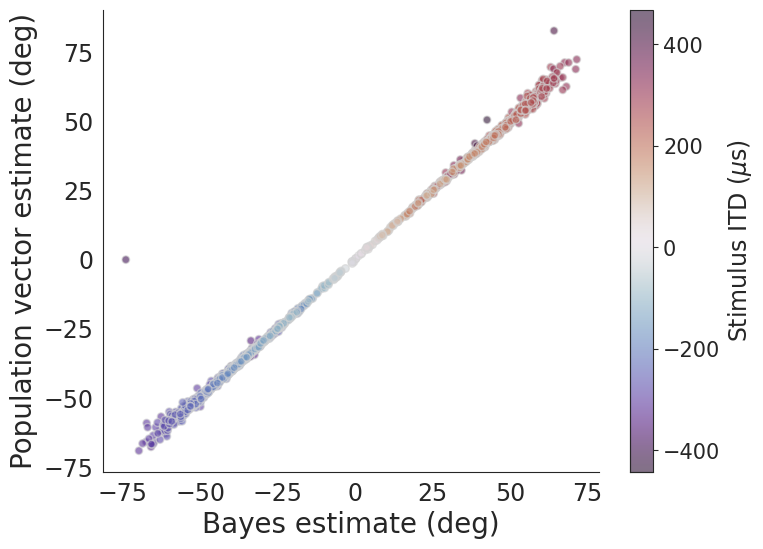

In [ ]:
plot_single_trial_estimates(bayes_estimate, pv_estimate, ITD)

plt.xticks(np.arange(-75, 100, 25))
plt.yticks(np.arange(-75, 100, 25))


plt.savefig("Figure_S3_5E.png", dpi=500)
files.download("Figure_S3_5E.png")

plt.show()

Figure 5F

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

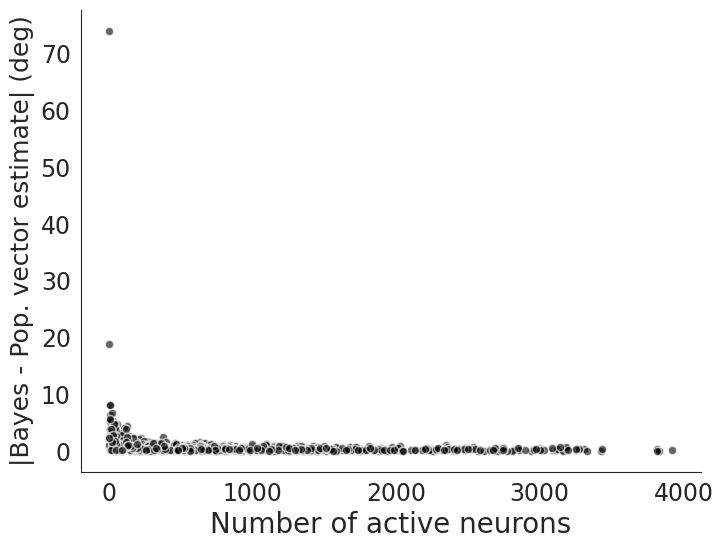

In [ ]:
plot_error_number_active(bayes_estimate.flatten(), pv_estimate.flatten(), number_active_neurons.flatten())

plt.savefig("Figure_S3_5F.png", dpi=500)
files.download("Figure_S3_5F.png")

plt.show()